# Full Model Comparison — BAB Benchmark (Position + Velocity)

This notebook trains and evaluates **22 models** on the BAB vibration benchmark,
comparing predicted **position** ($\theta$) and **velocity** ($\dot\theta$) across multiple excitation types.

Model families (consistent naming):

1. **Physics-based**: `LinearPhysics`, `StribeckPhysics`, `UDE`
2. **Neural 2-D continuous-time**: `VanillaNODE2D`, `StructuredNODE2D`, `AdaptiveNODE2D`, `VanillaNCDE2D`, `StructuredNCDE2D`, `AdaptiveNCDE2D`, `VanillaNSDE2D`, `StructuredNSDE2D`, `AdaptiveNSDE2D`
3. **Continuous-time 1-D wrappers (optional)**: `NeuralODE`, `NeuralSDE`, `NeuralCDE`
4. **Discrete-time**: `NARX`, `RandomForest`, `NeuralNetwork`, `GRU`, `LSTM`, `TCN`, `Mamba`

## 0) Imports and Setup

In [1]:
import sys, os
sys.path.insert(0, os.path.abspath(".."))

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torchsde
from torchdiffeq import odeint

# ── Repo modules ──
from src.data.dataset import Dataset

# Discrete-time models (BaseModel wrappers)
from src.models.narx import NARX
from src.models.gru import GRU
from src.models.lstm import LSTM
from src.models.random_forest import RandomForest
from src.models.neural_network import NeuralNetwork
from src.models.tcn import TCN
from src.models.mamba import Mamba

# Continuous-time models (BaseModel wrappers — 1D state)
from src.models.neural_ode import NeuralODE
from src.models.neural_sde import NeuralSDE
from src.models.neural_cde import NeuralCDE
from src.models.ude import UDE

# Physics-based ODE models
from src.models.physics_ode import (
    _build_linear_ode, _build_stribeck_ode,
    LinearPhysics, StribeckPhysics,
)
# Black-box 2-D Neural ODE models (raw nn.Module)
from src.models.blackbox_ode import (
    VanillaNODE2D,
    _build_vanilla, _build_structured, _build_adaptive,
)
# CDE-inspired 2-D controlled models
from src.models.blackbox_cde import (
    VanillaNCDE2D,
    _build_vanilla_ncde, _build_structured_ncde, _build_adaptive_ncde,
)
# Black-box 2-D Neural SDE models
from src.models.blackbox_sde import (
    VanillaNSDE2D,
    _build_vanilla_nsde, _build_structured_nsde, _build_adaptive_nsde,
)

# ── Constants ──
RESAMPLE = 50          # resample → 20 Hz
VEL_METHOD = "central" # central finite differences for ẏ
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

print("All imports OK ✓")


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/antonioalvarezlopez/Library/Python/3.12/lib/python/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/Users/antonioalvarezlopez/Library/Python/3.12/lib/python/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/Users/antonioalvarezlopez/Library/Python/3.12/lib/python/site-packages/ipykernel/kernelapp.py", lin

Device: cpu
All imports OK ✓


## 1) Data Loading and Split Definition (Train / Validation / Test)

- **Train base**: `multisine_05`, `multisine_06`, `swept_sine`
- **Validation**: para cada dataset de train base, se usa el tramo final temporal
  `N_val = max(round(N*VALIDATION_RATIO), MIN_VAL_SAMPLES)`.
- **Train final**: tramo inicial temporal de cada dataset de train base
  (sin fuga temporal train->val).
- **Test holdout**: `random_steps_01`, `random_steps_02` (nunca usados para ajuste de parametros).

Formalmente, para cada dataset de train base con longitud $N$:
$$
\text{cut} = N - N_{val},\quad
\mathcal{D}_{train}=\{0,\dots,\text{cut}-1\},\quad
\mathcal{D}_{val}=\{\text{cut},\dots,N-1\}
$$

Velocidad estimada (estado 2-D para modelos NODE2D/NCDE2D/NSDE2D):
$$
\dot{y}[k] = \frac{y[k+1]-y[k-1]}{2\,\Delta t}
$$

  Train-full:    multisine_05  |  N= 1101  |  Ts=0.05000s  |  T=55.0s
  Train-full:    multisine_06  |  N= 1101  |  Ts=0.05000s  |  T=55.0s
  Train-full:      swept_sine  |  N= 1100  |  Ts=0.05000s  |  T=54.9s
        Test: random_steps_01  |  N= 1101  |  Ts=0.05000s  |  T=55.0s
        Test: random_steps_02  |  N= 1101  |  Ts=0.05000s  |  T=55.0s
       Split:    multisine_05  |  N_train=  901  N_val=  200
       Split:    multisine_06  |  N_train=  901  N_val=  200
       Split:      swept_sine  |  N_train=  900  N_val=  200


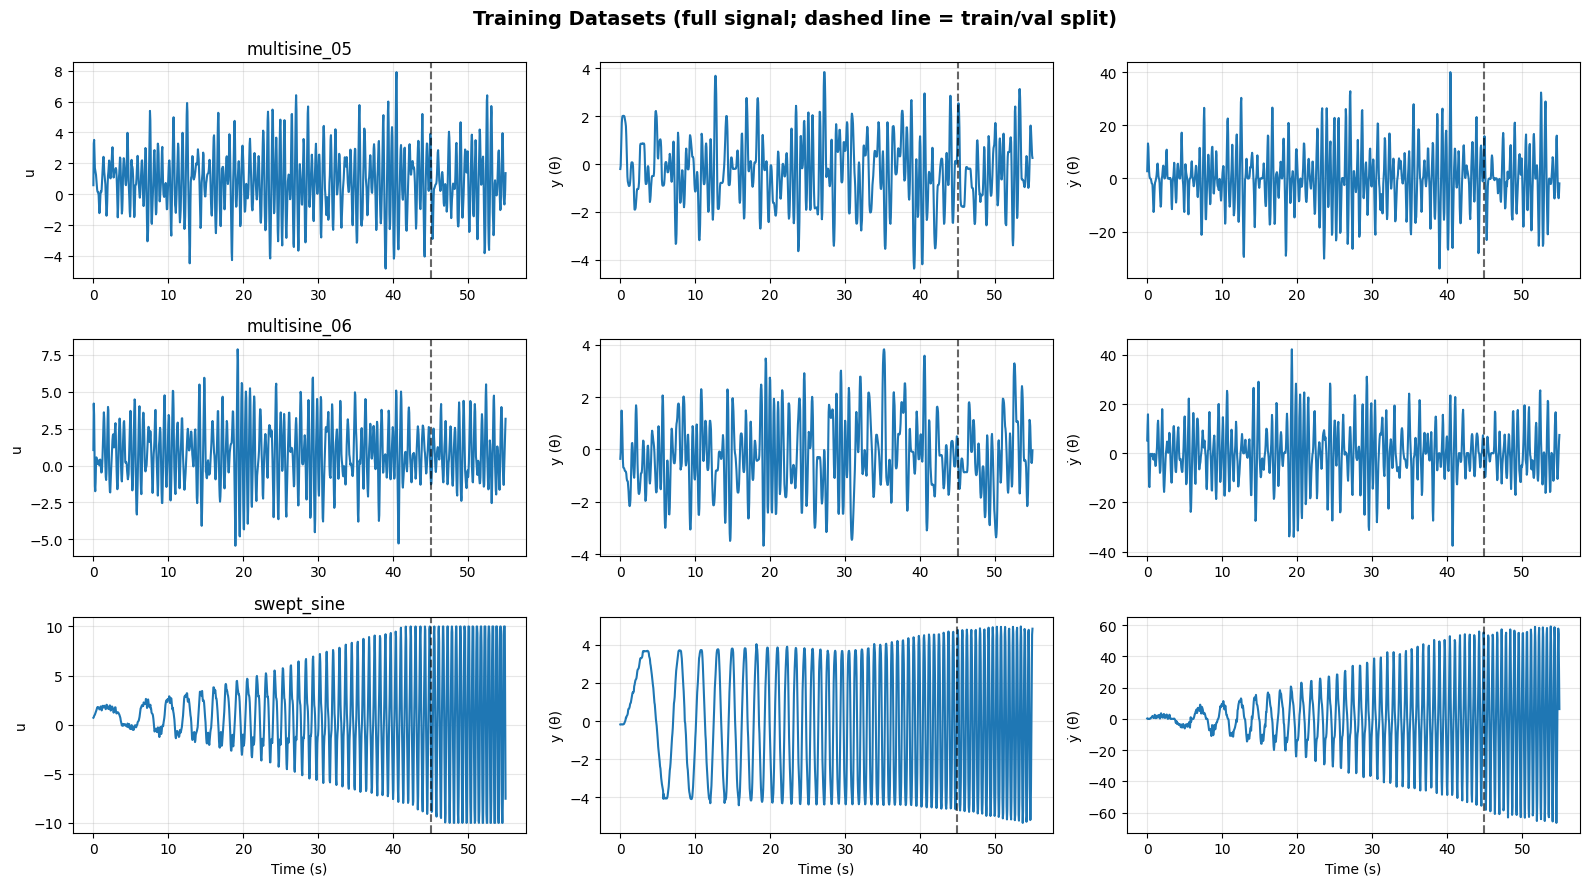

In [2]:
train_names = ["multisine_05", "multisine_06", "swept_sine"]
test_names  = ["random_steps_01", "random_steps_02"]

USE_VALIDATION = True
VALIDATION_RATIO = 0.15
MIN_VAL_SAMPLES = 200


def load_datasets(names, label=""):
    datasets = []
    for ds_name in names:
        ds = Dataset.from_bab_experiment(
            ds_name, preprocess=True, resample_factor=RESAMPLE,
            y_dot_method=VEL_METHOD,
        )
        dt = 1.0 / ds.sampling_rate
        datasets.append({
            "name": ds.name, "u": ds.u, "y": ds.y,
            "y_dot": ds.y_dot, "t": ds.t, "Ts": dt,
            "y_sim": np.column_stack([ds.y, ds.y_dot]),
        })
        print(f"  {label:>10s}: {ds.name:>15s}  |  N={len(ds):5d}  |  Ts={dt:.5f}s  |  T={ds.t[-1]:.1f}s")
    return datasets


def _slice_dataset(ds, start, stop, name=None):
    return {
        "name": ds["name"] if name is None else name,
        "u": ds["u"][start:stop],
        "y": ds["y"][start:stop],
        "y_dot": ds["y_dot"][start:stop],
        "t": ds["t"][start:stop] - ds["t"][start],
        "Ts": ds["Ts"],
        "y_sim": ds["y_sim"][start:stop],
    }


def split_train_validation(datasets, val_ratio=0.15, min_val_samples=200):
    train_split = []
    val_split = []

    for ds in datasets:
        n = len(ds["u"])
        n_val = max(int(round(n * val_ratio)), int(min_val_samples))
        n_val = min(n_val, n - 50)
        if n_val <= 0:
            raise ValueError(f"Dataset {ds['name']} is too short for validation split")

        cut = n - n_val
        train_split.append(_slice_dataset(ds, 0, cut, name=ds["name"]))
        val_split.append(_slice_dataset(ds, cut, n, name=ds["name"]))

        print(
            f"  {'Split':>10s}: {ds['name']:>15s}  |  "
            f"N_train={cut:5d}  N_val={n_val:5d}"
        )

    return train_split, val_split


train_datasets_full = load_datasets(train_names, "Train-full")
test_datasets = load_datasets(test_names, "Test")
if USE_VALIDATION:
    train_datasets, val_datasets = split_train_validation(
        train_datasets_full,
        val_ratio=VALIDATION_RATIO,
        min_val_samples=MIN_VAL_SAMPLES,
    )
else:
    train_datasets = train_datasets_full
    val_datasets = []
    print("Validation split disabled: using full train datasets for fitting")

# ── Quick overview ──
fig, axes = plt.subplots(len(train_datasets_full), 3, figsize=(16, 3 * len(train_datasets_full)),
                          sharex=False, squeeze=False)
for i, (ds_full, ds_fit) in enumerate(zip(train_datasets_full, train_datasets)):
    split_idx = len(ds_fit["u"]) - 1
    split_t = ds_full["t"][split_idx]

    axes[i, 0].plot(ds_full["t"], ds_full["u"])
    axes[i, 0].axvline(split_t, color="k", linestyle="--", alpha=0.6)
    axes[i, 0].set_ylabel("u")
    axes[i, 0].set_title(ds_full["name"])

    axes[i, 1].plot(ds_full["t"], ds_full["y"])
    axes[i, 1].axvline(split_t, color="k", linestyle="--", alpha=0.6)
    axes[i, 1].set_ylabel("y (θ)")

    axes[i, 2].plot(ds_full["t"], ds_full["y_dot"])
    axes[i, 2].axvline(split_t, color="k", linestyle="--", alpha=0.6)
    axes[i, 2].set_ylabel("ẏ (θ̇)")

    for ax in axes[i]:
        ax.grid(True, alpha=0.3)
for ax in axes[-1]:
    ax.set_xlabel("Time (s)")
fig.suptitle("Training Datasets (full signal; dashed line = train/val split)", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

## 2) Prepare Torch Tensors (Train + Test)

Each dataset is stored as a dict of tensors on the target device for
multi-dataset training (ODE models sample randomly across datasets each epoch).

In [3]:
def _to_tensors(datasets):
    out = []
    for ds in datasets:
        out.append({
            "t": torch.tensor(ds["t"], dtype=torch.float32).to(device),
            "u": torch.tensor(ds["u"], dtype=torch.float32).reshape(-1, 1).to(device),
            "y": torch.tensor(ds["y_sim"], dtype=torch.float32).to(device),
            "name": ds["name"],
        })
    return out


train_tensors = _to_tensors(train_datasets)
val_tensors = _to_tensors(val_datasets)
test_tensors  = _to_tensors(test_datasets)

primary = train_datasets[0]
all_ts_values = np.array([ds["Ts"] for ds in (train_datasets + val_datasets + test_datasets)], dtype=float)
dt = float(np.median(all_ts_values))
if not np.allclose(all_ts_values, dt, rtol=1e-4, atol=1e-8):
    raise ValueError(f"Datasets have incompatible sampling times (median={dt:.8f}): {all_ts_values}")

# Multi-dataset lists (continuous-time wrappers train with random batches)
u_train_list = [np.asarray(ds["u"], dtype=float).flatten() for ds in train_datasets]
y_train_list = [np.asarray(ds["y"], dtype=float).flatten() for ds in train_datasets]

# Concatenated arrays kept for discrete-time baselines
u_train_concat = np.concatenate(u_train_list)
y_train_concat = np.concatenate(y_train_list)

print(f"Training on {len(train_tensors)} datasets, validation on {len(val_tensors)}, testing on {len(test_tensors)}")
print(f"Random-batch train lengths: {[len(u) for u in u_train_list]}")
print(f"Concatenated samples (discrete baselines): {len(u_train_concat)}")

Training on 3 datasets, validation on 3, testing on 2
Random-batch train lengths: [901, 901, 900]
Concatenated samples (discrete baselines): 2702


## 3) Instantiate Models & Define Training / Simulation Helpers

### 3a) Shared training loop for ODE models (multiple-shooting, multi-dataset)

In [4]:
# ═══════════════════════════════════════════════════════════════
#  Training helpers
# ═══════════════════════════════════════════════════════════════

import inspect


def train_node_multi(
    model,
    name,
    epochs=5000,
    lr=0.01,
    k_steps=20,
    batch_size=128,
    log_every=500,
    eval_callback=None,
    eval_every=None,
):
    """Multi-dataset multiple-shooting training for any 2-D neural ODE."""
    if eval_every is None:
        eval_every = log_every
    eval_every = max(1, int(eval_every))

    print(f"--- Training {name}  (K={k_steps}, B={batch_size}, epochs={epochs}) ---")
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs + 1):
        ds = train_tensors[np.random.randint(len(train_tensors))]
        t_ds, u_ds, y_ds = ds["t"], ds["u"], ds["y"]
        dt_local = (t_ds[1] - t_ds[0]).item()
        t_eval = torch.arange(0, k_steps * dt_local, dt_local, device=device)

        model.u_series = u_ds
        model.t_series = t_ds

        optimizer.zero_grad()
        start_idx = np.random.randint(0, len(t_ds) - k_steps, size=batch_size)
        start_idx_t = torch.as_tensor(start_idx, dtype=torch.long, device=device)
        x0 = y_ds[start_idx_t]
        model.batch_start_times = t_ds[start_idx_t].reshape(-1, 1)

        pred = odeint(model, x0, t_eval, method="rk4")
        targets = torch.stack([y_ds[i : i + k_steps] for i in start_idx_t.tolist()], dim=1)
        loss = torch.mean((pred - targets) ** 2)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)
        optimizer.step()

        loss_value = float(loss.item())
        if epoch % log_every == 0:
            print(f"  Epoch {epoch:>5d} | Loss: {loss_value:.6f}  ({ds['name']})")

        if eval_callback is not None and epoch % eval_every == 0:
            eval_callback(model=model, epoch=epoch, train_loss=loss_value)

    return model


def train_sde_multi(
    model,
    name,
    epochs=5000,
    lr=0.01,
    k_steps=20,
    batch_size=128,
    sde_method="euler",
    log_every=500,
    eval_callback=None,
    eval_every=None,
):
    """Multi-dataset multiple-shooting training for any 2-D neural SDE."""
    if eval_every is None:
        eval_every = log_every
    eval_every = max(1, int(eval_every))

    print(f"--- Training {name}  (K={k_steps}, B={batch_size}, epochs={epochs}) ---")
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs + 1):
        ds = train_tensors[np.random.randint(len(train_tensors))]
        t_ds, u_ds, y_ds = ds["t"], ds["u"], ds["y"]
        dt_local = (t_ds[1] - t_ds[0]).item()
        t_eval = torch.arange(0, k_steps * dt_local, dt_local, device=device)

        model.u_series = u_ds
        model.t_series = t_ds

        optimizer.zero_grad()
        start_idx = np.random.randint(0, len(t_ds) - k_steps, size=batch_size)
        start_idx_t = torch.as_tensor(start_idx, dtype=torch.long, device=device)
        x0 = y_ds[start_idx_t]
        model.batch_start_times = t_ds[start_idx_t].reshape(-1, 1)

        pred = torchsde.sdeint(model, x0, t_eval, method=sde_method, dt=dt_local)
        targets = torch.stack([y_ds[i : i + k_steps] for i in start_idx_t.tolist()], dim=1)
        loss = torch.mean((pred - targets) ** 2)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)
        optimizer.step()

        loss_value = float(loss.item())
        if epoch % log_every == 0:
            print(f"  Epoch {epoch:>5d} | Loss: {loss_value:.6f}  ({ds['name']})")

        if eval_callback is not None and epoch % eval_every == 0:
            eval_callback(model=model, epoch=epoch, train_loss=loss_value)

    return model


# ═══════════════════════════════════════════════════════════════
#  Simulation & Metrics
# ═══════════════════════════════════════════════════════════════

def _predict_free_run_silent(model, u, y_initial):
    """Call predict_free_run without progress bars when supported."""
    kwargs = {}
    try:
        sig = inspect.signature(model.predict_free_run)
        if "show_progress" in sig.parameters:
            kwargs["show_progress"] = False
    except (TypeError, ValueError):
        pass
    return model.predict_free_run(u, y_initial, **kwargs)


def _tensor_to_numpy_safe(x):
    """Convert tensor to numpy even if torch->numpy bridge is unavailable."""
    x_cpu = x.detach().cpu()
    try:
        return x_cpu.numpy()
    except RuntimeError:
        return np.asarray(x_cpu.tolist())


def simulate_ode_2d(model, ds_tensors):
    """Full-trajectory simulation for a 2-D state ODE model (nn.Module).
    Returns (t_np, y_true_2d, y_pred_2d)."""
    t_ds, u_ds, y_ds = ds_tensors["t"], ds_tensors["u"], ds_tensors["y"]
    model.eval()
    model.u_series = u_ds
    model.t_series = t_ds
    with torch.no_grad():
        model.batch_start_times = torch.zeros(1, 1, device=device)
        x0 = y_ds[0].unsqueeze(0)
        pred = _tensor_to_numpy_safe(odeint(model, x0, t_ds, method="rk4").squeeze(1))
    return _tensor_to_numpy_safe(t_ds), _tensor_to_numpy_safe(y_ds), pred


def simulate_sde_2d(model, ds_tensors, deterministic=True):
    """Full-trajectory simulation for 2-D neural SDE models.
    If deterministic=True, integrates drift-only ODE for reproducible results."""
    t_ds, u_ds, y_ds = ds_tensors["t"], ds_tensors["u"], ds_tensors["y"]
    model.eval()
    model.u_series = u_ds
    model.t_series = t_ds
    with torch.no_grad():
        model.batch_start_times = torch.zeros(1, 1, device=device)
        x0 = y_ds[0].unsqueeze(0)
        if deterministic:
            pred = odeint(lambda t, x: model.f(t, x), x0, t_ds, method="rk4")
        else:
            dt_local = (t_ds[1] - t_ds[0]).item()
            pred = torchsde.sdeint(model, x0, t_ds, method="euler", dt=dt_local)
        pred = _tensor_to_numpy_safe(pred.squeeze(1))
    return _tensor_to_numpy_safe(t_ds), _tensor_to_numpy_safe(y_ds), pred


def simulate_physics_2d(model, ds_np):
    """Use the internal _simulate to get both [θ, θ̇]."""
    u_t = torch.tensor(
        ds_np["u"].reshape(-1, 1), dtype=torch.float32, device=model._device,
    )
    t_grid = torch.arange(
        len(ds_np["u"]), dtype=torch.float32, device=model._device,
    ) * model.dt
    theta0 = ds_np["y"][0]
    omega0 = (ds_np["y"][1] - ds_np["y"][0]) / model.dt if len(ds_np["y"]) > 1 else 0.0
    x0 = torch.tensor(
        [[theta0, omega0]], dtype=torch.float32, device=model._device,
    )
    model.ode_func_.eval()
    with torch.no_grad():
        pred = model._simulate(u_t, x0, t_grid)  # (T, 2)
    pred_np = _tensor_to_numpy_safe(pred)
    n = min(len(pred_np), len(ds_np["y_sim"]))
    return ds_np["t"][:n], ds_np["y_sim"][:n], pred_np[:n]


def simulate_discrete(model, ds_np):
    """Full-trajectory free-run simulation for discrete models (BaseModel).
    Returns (t, y_true_2d, y_pred_2d) where velocity is estimated from
    predicted position via central differences."""
    pred_pos = _predict_free_run_silent(model, ds_np["u"], ds_np["y"])
    ml = getattr(model, "max_lag", 0) or 0
    n = len(pred_pos)
    pred_vel = np.gradient(pred_pos[:n], ds_np["Ts"])
    y_pred = np.column_stack([pred_pos[:n], pred_vel])
    y_true = ds_np["y_sim"][ml : ml + n]
    t = ds_np["t"][ml : ml + n]
    return t, y_true, y_pred


def simulate_ct_1d(model, ds_np):
    """Simulation for continuous-time 1-D state models (NeuralODE, NeuralSDE,
    NeuralCDE, UDE).  These predict position only; velocity is estimated
    via finite differences from the predicted position trajectory.
    Returns (t, y_true_2d, y_pred_2d)."""
    pred_pos = _predict_free_run_silent(model, ds_np["u"], ds_np["y"])
    ml = getattr(model, "max_lag", 0) or 0
    n = len(pred_pos)
    pred_vel = np.gradient(pred_pos[:n], ds_np["Ts"])
    y_pred = np.column_stack([pred_pos[:n], pred_vel])
    y_true = ds_np["y_sim"][ml : ml + n]
    t = ds_np["t"][ml : ml + n]
    return t, y_true, y_pred


def compute_metrics(y_true, y_pred):
    """RMSE, R², FIT% for position and velocity."""
    res_pos = y_true[:, 0] - y_pred[:, 0]
    res_vel = y_true[:, 1] - y_pred[:, 1]
    rmse_pos = np.sqrt(np.mean(res_pos ** 2))
    rmse_vel = np.sqrt(np.mean(res_vel ** 2))
    ss_res_pos = np.sum(res_pos ** 2)
    ss_tot_pos = np.sum((y_true[:, 0] - np.mean(y_true[:, 0])) ** 2)
    ss_res_vel = np.sum(res_vel ** 2)
    ss_tot_vel = np.sum((y_true[:, 1] - np.mean(y_true[:, 1])) ** 2)
    r2_pos = 1 - ss_res_pos / ss_tot_pos if ss_tot_pos > 0 else np.nan
    r2_vel = 1 - ss_res_vel / ss_tot_vel if ss_tot_vel > 0 else np.nan
    denom_pos = np.linalg.norm(y_true[:, 0] - np.mean(y_true[:, 0]))
    denom_vel = np.linalg.norm(y_true[:, 1] - np.mean(y_true[:, 1]))
    fit_pos = 100 * (1 - np.linalg.norm(res_pos) / denom_pos) if denom_pos > 0 else np.nan
    fit_vel = 100 * (1 - np.linalg.norm(res_vel) / denom_vel) if denom_vel > 0 else np.nan
    return {
        "rmse_pos": rmse_pos,
        "rmse_vel": rmse_vel,
        "r2_pos": r2_pos,
        "r2_vel": r2_vel,
        "fit_pos": fit_pos,
        "fit_vel": fit_vel,
    }


def simulate_model_once(model, mtype, ds_np, ds_t):
    if mtype == "ode":
        return simulate_ode_2d(model, ds_t)
    if mtype == "sde2d":
        return simulate_sde_2d(model, ds_t, deterministic=True)
    if mtype == "physics":
        return simulate_physics_2d(model, ds_np)
    if mtype == "ct_1d":
        return simulate_ct_1d(model, ds_np)
    if mtype == "discrete":
        return simulate_discrete(model, ds_np)
    raise ValueError(f"Unknown model type: {mtype}")


def build_realtime_eval_splits(include_val=True, include_test=True):
    splits = []
    if include_val:
        splits.extend([("val", ds_np, ds_t) for ds_np, ds_t in zip(val_datasets, val_tensors)])
    if include_test:
        splits.extend([("test", ds_np, ds_t) for ds_np, ds_t in zip(test_datasets, test_tensors)])
    return splits


class RealtimeEvaluator:
    def __init__(self, model_name, mtype, eval_splits, eval_every=50):
        self.model_name = model_name
        self.mtype = mtype
        self.eval_splits = list(eval_splits)
        self.eval_every = max(1, int(eval_every))

    @staticmethod
    def _format_text_table(headers, rows):
        widths = [len(str(h)) for h in headers]
        for row in rows:
            for idx, val in enumerate(row):
                widths[idx] = max(widths[idx], len(str(val)))

        def _fmt(row):
            return " | ".join(str(val).ljust(widths[idx]) for idx, val in enumerate(row))

        sep = "-+-".join("-" * w for w in widths)
        lines = [_fmt(headers), sep]
        lines.extend(_fmt(row) for row in rows)
        return "\n".join(lines)

    def run(self, model, epoch, train_loss):
        if epoch % self.eval_every != 0:
            return

        headers = ["metric"]
        fit_row = ["FIT_theta (%)"]
        rmse_row = ["RMSE_theta"]
        r2_row = ["R2_theta"]
        fit_vel_row = ["FIT_omega (%)"]
        rmse_vel_row = ["RMSE_omega"]
        r2_vel_row = ["R2_omega"]
        status_row = ["status"]

        for split, ds_np, ds_t in self.eval_splits:
            ds_label = f"{split}:{ds_np['name']}"
            headers.append(ds_label)
            try:
                _, y_true, y_pred = simulate_model_once(model, self.mtype, ds_np, ds_t)
                m = compute_metrics(y_true, y_pred)
                fit_row.append(f"{m['fit_pos']:.2f}")
                rmse_row.append(f"{m['rmse_pos']:.5f}")
                r2_row.append(f"{m['r2_pos']:.5f}")
                fit_vel_row.append(f"{m['fit_vel']:.2f}")
                rmse_vel_row.append(f"{m['rmse_vel']:.5f}")
                r2_vel_row.append(f"{m['r2_vel']:.5f}")
                status_row.append("OK")
            except Exception as exc:
                fit_row.append("-")
                rmse_row.append("-")
                r2_row.append("-")
                fit_vel_row.append("-")
                rmse_vel_row.append("-")
                r2_vel_row.append("-")
                status_row.append(f"ERR:{type(exc).__name__}")

        table = self._format_text_table(headers, [fit_row, rmse_row, r2_row, fit_vel_row, rmse_vel_row, r2_vel_row, status_row])
        print(f"  [RT] {self.model_name:<16s} | ep {epoch:>5d} | train {train_loss:.6f}")
        print(table)


class WandbLikeRealtimeLogger:
    """Adapter: reuses existing wandb hooks to run realtime evaluation callbacks."""

    def __init__(self, model, realtime_evaluator):
        self.model = model
        self.realtime_evaluator = realtime_evaluator

    def log(self, payload, step=None):
        epoch = int(payload.get("train/epoch", step if step is not None else 0))
        train_loss = float(payload.get("train/loss", np.nan))
        self.realtime_evaluator.run(model=self.model, epoch=epoch, train_loss=train_loss)


print("Training / simulation / realtime-eval helpers defined ✓")


# ═══════════════════════════════════════════════════════════════
#  Immediate per-model evaluation + plotting
# ═══════════════════════════════════════════════════════════════

results_live = {}


def collect_eval_splits(include_train=True, include_val=False, include_test=True):
    splits = []
    if include_train:
        splits.extend([("train", ds_np, ds_t) for ds_np, ds_t in zip(train_datasets, train_tensors)])
    if include_val and len(val_datasets) > 0:
        splits.extend([("val", ds_np, ds_t) for ds_np, ds_t in zip(val_datasets, val_tensors)])
    if include_test:
        splits.extend([("test", ds_np, ds_t) for ds_np, ds_t in zip(test_datasets, test_tensors)])
    return splits


def evaluate_model_results(model_name, model_obj, mtype, eval_splits):
    model_results = {"train": {}, "val": {}, "test": {}}

    for split, ds_np, ds_t in eval_splits:
        t_np, y_true, y_pred = simulate_model_once(model_obj, mtype, ds_np, ds_t)
        m = compute_metrics(y_true, y_pred)
        m["t"] = t_np
        m["y_true"] = y_true
        m["y_pred"] = y_pred
        model_results[split][ds_np["name"]] = m

    return model_results


def _print_split_summary(model_name, split_name, split_results):
    if not split_results:
        return
    parts = []
    for ds_name, r in split_results.items():
        parts.append(
            f"{ds_name}: FITθ={r['fit_pos']:.2f}% RMSEθ={r['rmse_pos']:.5f} R2θ={r['r2_pos']:.5f}"
        )
    print(f"  [{model_name}] {split_name.upper()} -> " + " | ".join(parts))


def plot_model_split(model_name, model_results, split):
    split_results = model_results.get(split, {})
    if not split_results:
        return

    ds_names = list(split_results.keys())
    n_rows = len(ds_names)

    # Figure 1: measured vs predicted trajectories
    fig_pred, axes_pred = plt.subplots(n_rows, 2, figsize=(16, max(4, 3.2 * n_rows)), squeeze=False)

    for i, ds_name in enumerate(ds_names):
        r = split_results[ds_name]
        t = r["t"]
        y_true = r["y_true"]
        y_pred = r["y_pred"]

        ax_pos = axes_pred[i, 0]
        ax_vel = axes_pred[i, 1]

        ax_pos.plot(t, y_true[:, 0], color="black", lw=2.0, alpha=0.8, label="Measured")
        ax_pos.plot(t, y_pred[:, 0], color="tab:blue", lw=1.4, label=f"Pred (FIT={r['fit_pos']:.2f}%, R2={r['r2_pos']:.4f})")
        ax_pos.set_ylabel(f"{ds_name}\nθ")
        ax_pos.grid(True, alpha=0.3)
        ax_pos.legend(loc="upper left", bbox_to_anchor=(1.02, 1.0), borderaxespad=0.0, fontsize=8)

        ax_vel.plot(t, y_true[:, 1], color="black", lw=2.0, alpha=0.8, label="Measured")
        ax_vel.plot(t, y_pred[:, 1], color="tab:orange", lw=1.4, label=f"Pred (FIT={r['fit_vel']:.2f}%, R2={r['r2_vel']:.4f})")
        ax_vel.set_ylabel("θ̇")
        ax_vel.grid(True, alpha=0.3)
        ax_vel.legend(loc="upper left", bbox_to_anchor=(1.02, 1.0), borderaxespad=0.0, fontsize=8)

        if i == n_rows - 1:
            ax_pos.set_xlabel("Time (s)")
            ax_vel.set_xlabel("Time (s)")

    axes_pred[0, 0].set_title(f"{model_name} — {split.upper()} — Position")
    axes_pred[0, 1].set_title(f"{model_name} — {split.upper()} — Velocity")
    plt.tight_layout(rect=[0, 0, 0.82, 1])
    plt.show()

    # Figure 2: residuals (measured - predicted)
    fig_res, axes_res = plt.subplots(n_rows, 2, figsize=(16, max(4, 3.0 * n_rows)), squeeze=False)

    for i, ds_name in enumerate(ds_names):
        r = split_results[ds_name]
        t = r["t"]
        y_true = r["y_true"]
        y_pred = r["y_pred"]

        res_pos = y_true[:, 0] - y_pred[:, 0]
        res_vel = y_true[:, 1] - y_pred[:, 1]

        ax_res_pos = axes_res[i, 0]
        ax_res_vel = axes_res[i, 1]

        ax_res_pos.plot(t, res_pos, color="tab:blue", lw=1.2, label=f"Residual θ (RMSE={r['rmse_pos']:.4f})")
        ax_res_pos.axhline(0.0, color="black", ls="--", lw=1.0, alpha=0.8)
        ax_res_pos.set_ylabel(f"{ds_name}\nθ - θ̂")
        ax_res_pos.grid(True, alpha=0.3)
        ax_res_pos.legend(loc="upper left", bbox_to_anchor=(1.02, 1.0), borderaxespad=0.0, fontsize=8)

        ax_res_vel.plot(t, res_vel, color="tab:orange", lw=1.2, label=f"Residual θ̇ (RMSE={r['rmse_vel']:.4f})")
        ax_res_vel.axhline(0.0, color="black", ls="--", lw=1.0, alpha=0.8)
        ax_res_vel.set_ylabel("θ̇ - θ̇̂")
        ax_res_vel.grid(True, alpha=0.3)
        ax_res_vel.legend(loc="upper left", bbox_to_anchor=(1.02, 1.0), borderaxespad=0.0, fontsize=8)

        if i == n_rows - 1:
            ax_res_pos.set_xlabel("Time (s)")
            ax_res_vel.set_xlabel("Time (s)")

    axes_res[0, 0].set_title(f"{model_name} — {split.upper()} — Residuals (Position)")
    axes_res[0, 1].set_title(f"{model_name} — {split.upper()} — Residuals (Velocity)")
    plt.tight_layout(rect=[0, 0, 0.82, 1])
    plt.show()


def evaluate_and_plot_model(
    model_name,
    model_obj,
    mtype,
    include_train=True,
    include_val=False,
    include_test=True,
):
    eval_splits = collect_eval_splits(
        include_train=include_train,
        include_val=include_val,
        include_test=include_test,
    )
    model_results = evaluate_model_results(model_name, model_obj, mtype, eval_splits)
    results_live[model_name] = model_results

    if include_train:
        _print_split_summary(model_name, "train", model_results["train"])
        plot_model_split(model_name, model_results, "train")
    if include_val:
        _print_split_summary(model_name, "val", model_results["val"])
        plot_model_split(model_name, model_results, "val")
    if include_test:
        _print_split_summary(model_name, "test", model_results["test"])
        plot_model_split(model_name, model_results, "test")

    return model_results


print("Immediate evaluate+plot helpers defined ✓")

Training / simulation / realtime-eval helpers defined ✓
Immediate evaluate+plot helpers defined ✓


### 3b) Instantiate all models

Naming convention used in this notebook:

- `*NODE2D`, `*NCDE2D`, `*NSDE2D` -> neural continuous-time models with 2-D state $x=[\theta,\dot\theta]^\top`
- `NeuralODE`, `NeuralSDE`, `NeuralCDE`, `UDE` -> wrappers predicting $\theta$ (velocity is estimated for metrics)
- `LinearPhysics`, `StribeckPhysics` -> physics-based wrappers
- `NARX`, `RandomForest`, `NeuralNetwork`, `GRU`, `LSTM`, `TCN`, `Mamba` -> discrete-time baselines

- **2-D ODE/CDE-inspired models** (raw `nn.Module`): `LinearPhysicsODE`, `StribeckPhysicsODE`, `VanillaNODE2D`, `StructuredNODE2D`, `AdaptiveNODE2D`, `VanillaNCDE2D`, `StructuredNCDE2D`, `AdaptiveNCDE2D`
- **2-D SDE models** (raw `nn.Module`): `VanillaNSDE2D`, `StructuredNSDE2D`, `AdaptiveNSDE2D`
- **Physics-based wrappers** (`BaseModel`): `LinearPhysics`, `StribeckPhysics`, `UDE`
- **Continuous-time 1-D wrappers** (`BaseModel`): `NeuralODE`, `NeuralSDE`, `NeuralCDE`
- **Discrete wrappers** (`BaseModel`): `NARX`, `RandomForest`, `NeuralNetwork`, `GRU`, `LSTM`, `TCN`, `Mamba`

In [5]:
# ── Group 1: 2-D state ODE models (raw nn.Module, trained with train_node_multi) ──
linear_ode   = _build_linear_ode().to(device)
stribeck_ode = _build_stribeck_ode().to(device)

vanilla_ode    = _build_vanilla(hidden_dim=128).to(device)
structured_ode = _build_structured(hidden_dim=128).to(device)
adaptive_ode   = _build_adaptive(hidden_dim=128).to(device)

vanilla_ncde    = _build_vanilla_ncde(hidden_dim=128).to(device)
structured_ncde = _build_structured_ncde(hidden_dim=128).to(device)
adaptive_ncde   = _build_adaptive_ncde(hidden_dim=128).to(device)

vanilla_nsde    = _build_vanilla_nsde(hidden_dim=128).to(device)
structured_nsde = _build_structured_nsde(hidden_dim=128).to(device)
adaptive_nsde   = _build_adaptive_nsde(hidden_dim=128).to(device)

# ── Group 2: Physics-based BaseModel wrappers ──
linear_model   = LinearPhysics(dt=dt, solver="rk4", learning_rate=1e-3, epochs=1000, training_mode="subsequence")
stribeck_model = StribeckPhysics(dt=dt, solver="rk4", learning_rate=1e-3, epochs=1000, training_mode="subsequence")

ude_model = UDE(
    sampling_time=dt, tau=1.0, hidden_layers=[96, 96],
    lr=7e-4, epochs=1500, sequence_length=64,
    integration_substeps=3, training_mode="subsequence",
    sequences_per_epoch=32, patience=300, min_delta=1e-6,
    omega_loss_weight=0.2,
)

# ── Group 3: Continuous-time 1-D BaseModel wrappers (optional) ──
RUN_CT1D_MODELS = False

neural_ode_model = None
neural_sde_model = None
neural_cde_model = None
if RUN_CT1D_MODELS:
    neural_ode_model = NeuralODE(
        state_dim=1, input_dim=1, hidden_layers=[64, 64],
        solver="rk4", dt=dt, learning_rate=1e-3, epochs=1000,
        sequence_length=50, activation="selu", training_mode="subsequence",
        sequences_per_epoch=24,
    )
    neural_sde_model = NeuralSDE(
        state_dim=1, input_dim=1, hidden_layers=[64, 64],
        diffusion_hidden_layers=[64, 64], solver="euler",
        dt=dt, lr=1e-3, epochs=1000, sequence_length=50,
        sequences_per_epoch=24,
    )
    neural_cde_model = NeuralCDE(
        hidden_dim=32, input_dim=2, hidden_layers=[64, 64],
        interpolation="cubic", solver="rk4",
        lr=1e-3, epochs=1000, sequence_length=50,
        windows_per_epoch=24,
    )
else:
    print("Skipping CT 1D wrappers by default (RUN_CT1D_MODELS=False)")

# ── Group 4: Discrete-time BaseModel wrappers ──
narx_model = NARX(max_lag=10)
rf_model   = RandomForest(nu=10, ny=10, n_estimators=100, max_depth=12, random_state=42)
nn_model   = NeuralNetwork(nu=10, ny=10, hidden_layers=[80, 80, 80], activation="selu",
                            lr=1e-3, epochs=200, batch_size=32)
gru_model  = GRU(hidden_size=64, num_layers=2, epochs=200)
lstm_model = LSTM(hidden_size=64, num_layers=2, epochs=200)
tcn_model  = TCN(nu=10, ny=10, num_channels=[64, 64, 64, 64], kernel_size=3,
                  dropout=0.1, lr=1e-3, epochs=200, batch_size=32)
mamba_model = Mamba(nu=10, ny=10, d_model=64, d_state=16, d_conv=4,
                     n_layers=2, expand_factor=2, dropout=0.1,
                     lr=1e-3, epochs=200, batch_size=32)

# ── Print parameter counts ──
def count_params(m):
    return sum(p.numel() for p in m.parameters() if p.requires_grad)

print("Model parameter counts:")
for name, m in [
    ("LinearPhysics",   linear_ode),
    ("StribeckPhysics", stribeck_ode),
    ("VanillaNODE2D",   vanilla_ode),
    ("StructuredNODE2D",  structured_ode),
    ("AdaptiveNODE2D",    adaptive_ode),
    ("VanillaNCDE2D",   vanilla_ncde),
    ("StructuredNCDE2D",  structured_ncde),
    ("AdaptiveNCDE2D",    adaptive_ncde),
    ("VanillaNSDE2D",   vanilla_nsde),
    ("StructuredNSDE2D",  structured_nsde),
    ("AdaptiveNSDE2D",    adaptive_nsde),
]:
    print(f"  {name:<20s}: {count_params(m):>8,d}")
print(f"  {'NARX':<20s}: (non-parametric)")
print(f"  {'RandomForest':<20s}: (non-parametric)")
for name, m in [
    ("NeuralNetwork", nn_model),
    ("GRU",           gru_model),
    ("LSTM",          lstm_model),
    ("TCN",           tcn_model),
    ("Mamba",         mamba_model),
]:
    if hasattr(m, "model") and m.model is not None:
        print(f"  {name:<20s}: {count_params(m.model):>8,d}")
    else:
        print(f"  {name:<20s}: (created at fit)")
print(f"\nTotal models: 22")






# Realtime monitoring splits (validation + test)
rt_eval_splits = build_realtime_eval_splits(include_val=True, include_test=True)

Skipping CT 1D wrappers by default (RUN_CT1D_MODELS=False)
Model parameter counts:
  LinearPhysics       :        5
  StribeckPhysics     :        9
  VanillaNODE2D       :   25,410
  StructuredNODE2D    :   25,345
  AdaptiveNODE2D      :   25,666
  VanillaNCDE2D       :   25,538
  StructuredNCDE2D    :   25,473
  AdaptiveNCDE2D      :   25,858
  VanillaNSDE2D       :   25,796
  StructuredNSDE2D    :   25,666
  AdaptiveNSDE2D      :   25,987
  NARX                : (non-parametric)
  RandomForest        : (non-parametric)
  NeuralNetwork       : (created at fit)
  GRU                 : (created at fit)
  LSTM                : (created at fit)
  TCN                 : (created at fit)
  Mamba               : (created at fit)

Total models: 22


## 4) Training — VanillaNODE2D (black-box 2-D ODE)

Learned dynamics:
$$
\dot{x}(t)=f_{\Theta}(x(t),u(t)),\quad x=[\theta,\dot\theta]^\top
$$

Neural network used in this notebook (`hidden_dim=128`):
$$
[\theta,\dot\theta,u]\in\mathbb{R}^3\xrightarrow{\mathrm{Linear}(3,128)+\mathrm{SELU}+\mathrm{AlphaDropout}(0.05)}\xrightarrow{\mathrm{Linear}(128,128)+\mathrm{SELU}+\mathrm{AlphaDropout}(0.05)}\xrightarrow{\mathrm{Linear}(128,64)+\mathrm{SELU}}\xrightarrow{\mathrm{Linear}(64,2)}[\dot\theta,\ddot\theta]
$$
- The control input is evaluated as linearly interpolated $u(t)$ at solver time.

Batching strategy (time windows):
- At each epoch, one training dataset is sampled from `{multisine_05, multisine_06, swept_sine}`.
- Then `B=128` random start times are sampled in that dataset.
- Each sampled segment is a window of `K=20` samples (`k_steps=20`), i.e. approximately `K*Ts ≈ 1.0 s` because `Ts ≈ 0.05 s`.

Optimization problem:
$$
\min_{\Theta}\;\mathcal{L}_{\mathrm{MS}}(\Theta)
=\frac{1}{BK}\sum_{b=1}^{B}\sum_{k=1}^{K}
\left\|\hat{x}^{(b)}_{k}(\Theta)-x^{(b)}_{k}\right\|_2^2
$$

--- Training VanillaNODE2D  (K=20, B=128, epochs=5000) ---
  Epoch     0 | Loss: 126.361549  (multisine_06)
  [RT] VanillaNODE2D    | ep     0 | train 126.361549 | val:multisine_05 FITθ=-30.27% RMSEθ=1.68864 | val:multisine_06 FITθ=-14.27% RMSEθ=1.51982 | val:swept_sine FITθ=-27.83% RMSEθ=4.71809 | test:random_steps_01 FITθ=-5.56% RMSEθ=2.69076 | test:random_steps_02 FITθ=-3.26% RMSEθ=2.57447
  Epoch   500 | Loss: 0.606662  (multisine_05)
  [RT] VanillaNODE2D    | ep   500 | train 0.606662 | val:multisine_05 FITθ=20.51% RMSEθ=1.03038 | val:multisine_06 FITθ=13.54% RMSEθ=1.14988 | val:swept_sine FITθ=-137.90% RMSEθ=8.78075 | test:random_steps_01 FITθ=-120.49% RMSEθ=5.62003 | test:random_steps_02 FITθ=-92.16% RMSEθ=4.79084
  Epoch  1000 | Loss: 0.479707  (swept_sine)
  [RT] VanillaNODE2D    | ep  1000 | train 0.479707 | val:multisine_05 FITθ=63.93% RMSEθ=0.46752 | val:multisine_06 FITθ=75.87% RMSEθ=0.32092 | val:swept_sine FITθ=68.77% RMSEθ=1.15251 | test:random_steps_01 FITθ=27.46% RMSE

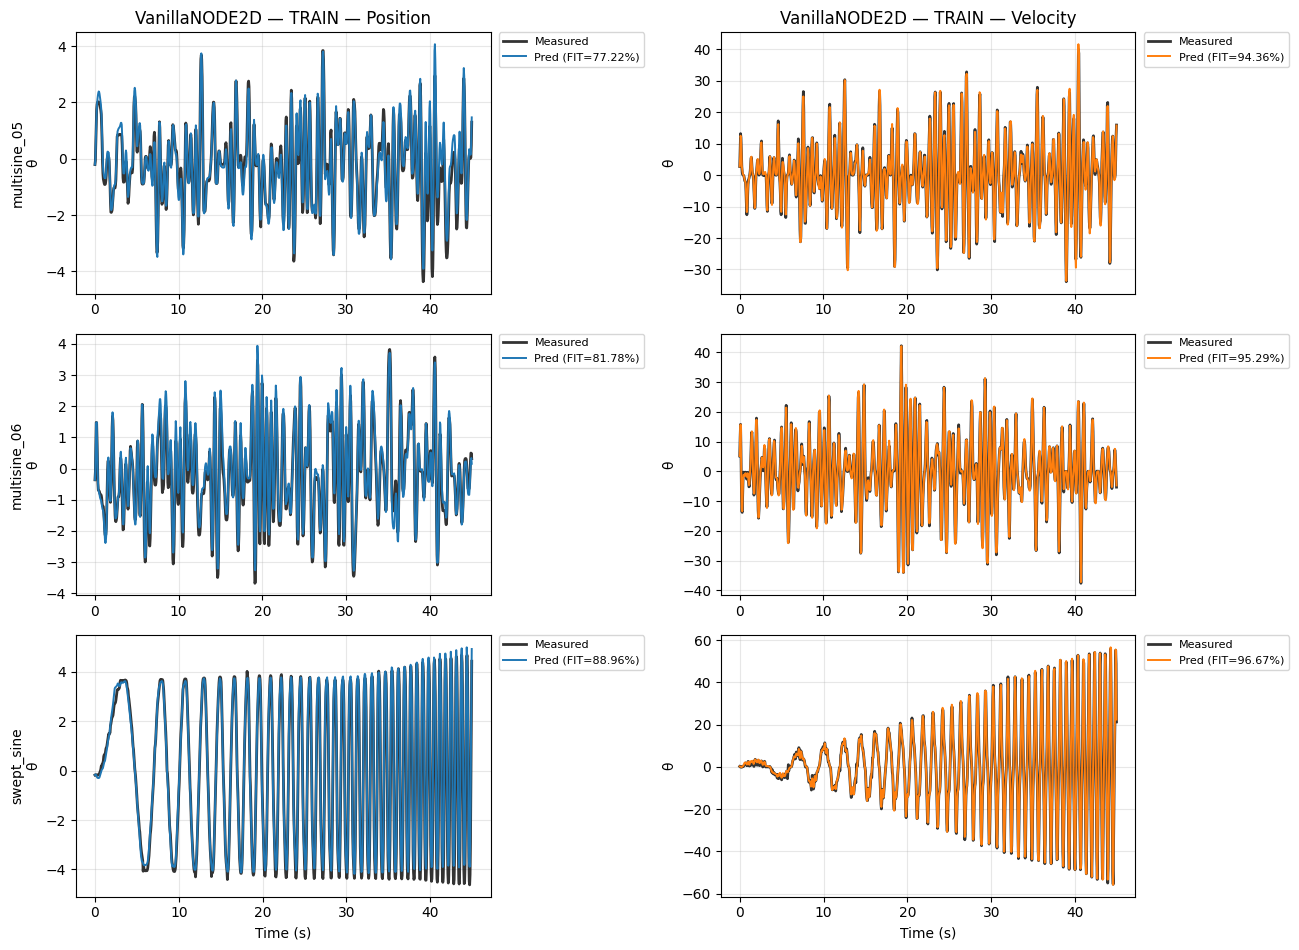

  [VanillaNODE2D] TEST -> random_steps_01: FITθ=9.34% RMSEθ=2.31088 | random_steps_02: FITθ=14.97% RMSEθ=2.11992


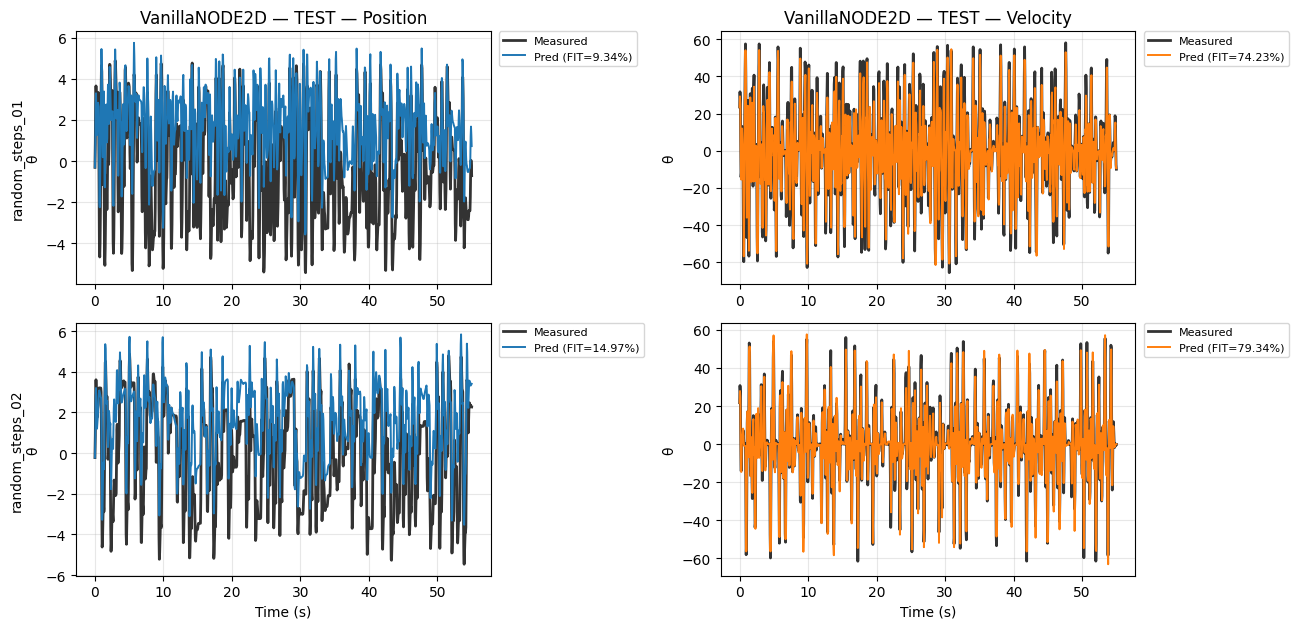

In [6]:
vanilla_ode_eval = RealtimeEvaluator(
    "VanillaNODE2D", "ode", rt_eval_splits, eval_every=500,
)
vanilla_ode = train_node_multi(
    vanilla_ode,
    "VanillaNODE2D",
    epochs=5000,
    lr=0.01,
    k_steps=20,
    batch_size=128,
    log_every=500,
    eval_callback=vanilla_ode_eval.run,
    eval_every=500,
)
_ = evaluate_and_plot_model("VanillaNODE2D", vanilla_ode, "ode", include_train=True, include_test=True)

## 5) Training — StructuredNODE2D (kinematic prior)

Dynamics:
$$
\dot{\theta}=\omega,\qquad
\dot{\omega}=f_{\Theta}(\theta,\omega,u)
$$

Neural network used in this notebook (`hidden_dim=128`):
$$
[\theta,\dot\theta,u]\in\mathbb{R}^3\xrightarrow{\mathrm{Linear}(3,128)+\mathrm{SELU}+\mathrm{AlphaDropout}(0.05)}\xrightarrow{\mathrm{Linear}(128,128)+\mathrm{SELU}+\mathrm{AlphaDropout}(0.05)}\xrightarrow{\mathrm{Linear}(128,64)+\mathrm{SELU}}\xrightarrow{\mathrm{Linear}(64,1)}\ddot\theta
$$
- Kinematics are explicit: $\dot\theta=\omega$ is hardcoded and only acceleration is learned.

Batching strategy (time windows):
- Same multiple-shooting setup as VanillaNODE2D.
- Per epoch: one train dataset + `B=128` sampled windows.
- Window length: `K=20` samples (`k_steps=20`) `≈ 1.0 s`.

Optimization problem:
$$
\min_{\Theta}\;\mathcal{L}_{\mathrm{MS}}(\Theta)
=\frac{1}{BK}\sum_{b=1}^{B}\sum_{k=1}^{K}
\left\|\hat{x}^{(b)}_{k}(\Theta)-x^{(b)}_{k}\right\|_2^2
$$

--- Training StructuredNODE2D  (K=20, B=128, epochs=5000) ---
  Epoch     0 | Loss: 366.834045  (swept_sine)
  [RT] StructuredNODE2D | ep     0 | train 366.834045 | val:multisine_05 FITθ=-619.45% RMSEθ=9.32589 | val:multisine_06 FITθ=-387.29% RMSEθ=6.48087 | val:swept_sine FITθ=-11.71% RMSEθ=4.12311 | test:random_steps_01 FITθ=-230.63% RMSEθ=8.42756 | test:random_steps_02 FITθ=-205.31% RMSEθ=7.61182
  Epoch   500 | Loss: 0.228511  (multisine_05)
  [RT] StructuredNODE2D | ep   500 | train 0.228511 | val:multisine_05 FITθ=74.27% RMSEθ=0.33357 | val:multisine_06 FITθ=53.29% RMSEθ=0.62120 | val:swept_sine FITθ=71.53% RMSEθ=1.05067 | test:random_steps_01 FITθ=22.82% RMSEθ=1.96714 | test:random_steps_02 FITθ=38.36% RMSEθ=1.53671
  Epoch  1000 | Loss: 0.336890  (multisine_05)
  [RT] StructuredNODE2D | ep  1000 | train 0.336890 | val:multisine_05 FITθ=74.53% RMSEθ=0.33014 | val:multisine_06 FITθ=86.63% RMSEθ=0.17777 | val:swept_sine FITθ=8.82% RMSEθ=3.36534 | test:random_steps_01 FITθ=48.83% R

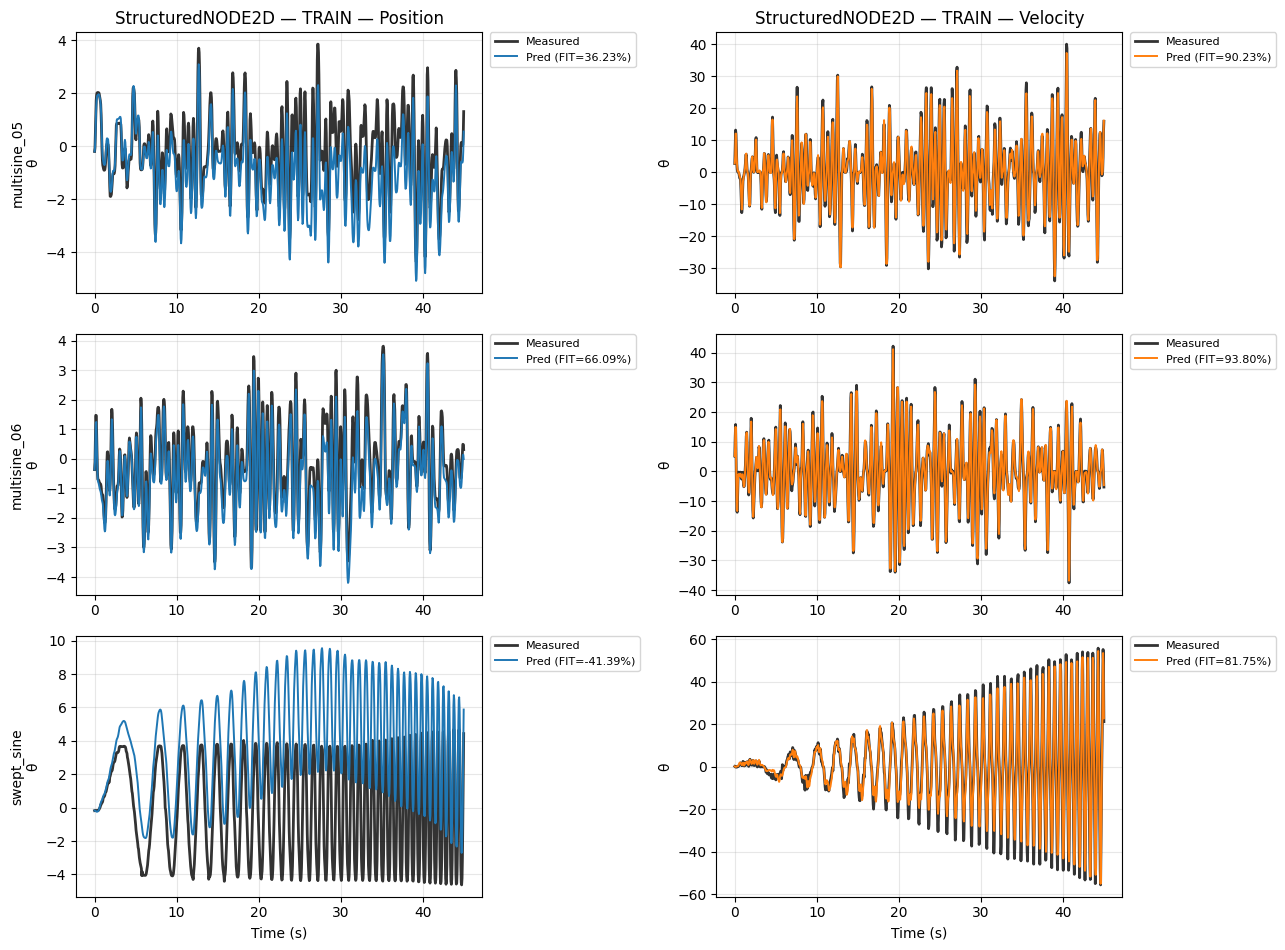

  [StructuredNODE2D] TEST -> random_steps_01: FITθ=1.41% RMSEθ=2.51311 | random_steps_02: FITθ=12.31% RMSEθ=2.18631


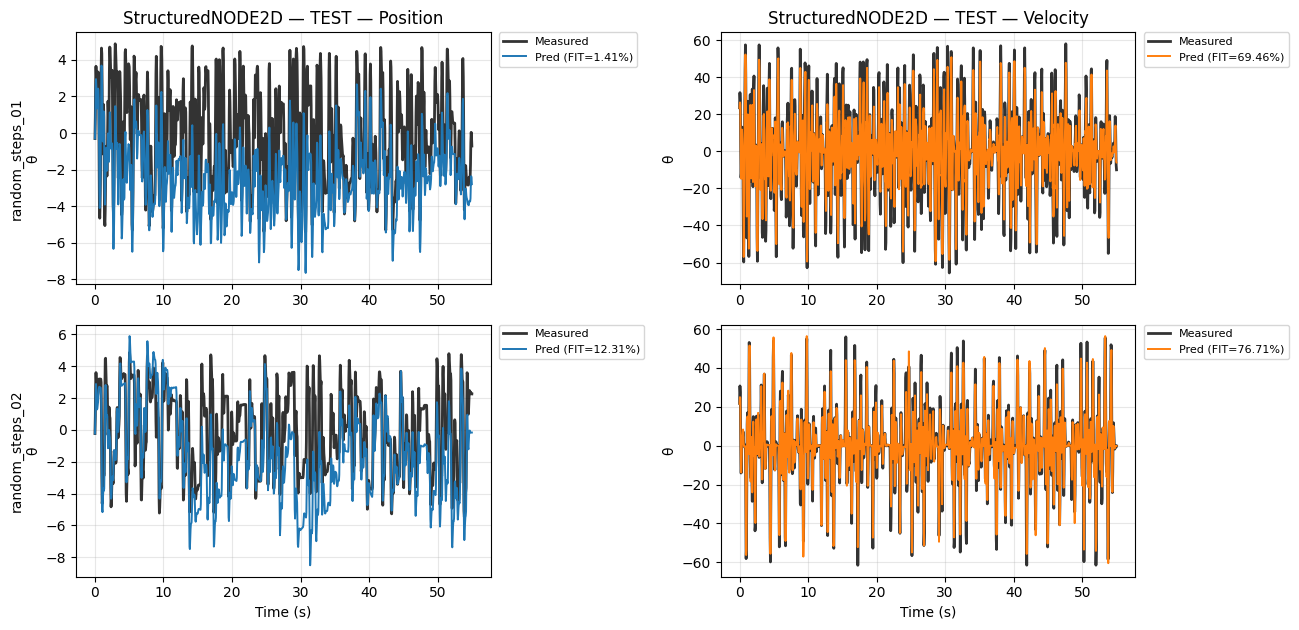

In [7]:
structured_ode_eval = RealtimeEvaluator(
    "StructuredNODE2D", "ode", rt_eval_splits, eval_every=500,
)
structured_ode = train_node_multi(
    structured_ode,
    "StructuredNODE2D",
    epochs=5000,
    lr=0.01,
    k_steps=20,
    batch_size=128,
    log_every=500,
    eval_callback=structured_ode_eval.run,
    eval_every=500,
)
_ = evaluate_and_plot_model("StructuredNODE2D", structured_ode, "ode", include_train=True, include_test=True)

## 6) Training — AdaptiveNODE2D (structured base + residual correction)

Dynamics:
$$
\dot{\theta}=\omega,\qquad
\dot{\omega}=f_{\Theta,\mathrm{base}}(\theta,\omega,u)+f_{\Theta,\mathrm{res}}(\theta,\omega,u)
$$

What is **base** vs **residual** here:
- $f_{\Theta,\mathrm{base}}$: the main structured acceleration model (same role as StructuredNODE2D), responsible for the dominant dynamics.
- $f_{\Theta,\mathrm{res}}$: a corrective term for mismatch/unmodeled effects; initialized near zero so early training behaves close to the base model.

Neural networks used in this notebook (`hidden_dim=128`):
$$
f_{\Theta,\mathrm{base}}:\,[\theta,\dot\theta,u]\in\mathbb{R}^{3}\xrightarrow{\mathrm{Linear}(3,128)+\mathrm{SELU}+\mathrm{AlphaDropout}(0.05)}\xrightarrow{\mathrm{Linear}(128,128)+\mathrm{SELU}+\mathrm{AlphaDropout}(0.05)}\xrightarrow{\mathrm{Linear}(128,64)+\mathrm{SELU}}\xrightarrow{\mathrm{Linear}(64,1)}\ddot\theta_{\mathrm{base}}
$$
$$
f_{\Theta,\mathrm{res}}:\,[\theta,\dot\theta,u]\in\mathbb{R}^{3}\xrightarrow{\mathrm{Linear}(3,64)+\tanh}\xrightarrow{\mathrm{Linear}(64,1)}\ddot\theta_{\mathrm{res}}
$$
- Residual is near-zero at initialization (`final weight *= 0.01`, `bias = 0`) in code.

Batching strategy (time windows):
- Per epoch: one train dataset + `B=128` sampled windows.
- Window length: `K=20` samples (`k_steps=20`) `≈ 1.0 s`.

Optimization problem:
$$
\min_{\Theta}\;\mathcal{L}_{\mathrm{MS}}(\Theta)
=\frac{1}{BK}\sum_{b=1}^{B}\sum_{k=1}^{K}
\left\|\hat{x}^{(b)}_{k}(\Theta)-x^{(b)}_{k}\right\|_2^2
$$

--- Training AdaptiveNODE2D  (K=20, B=128, epochs=5000) ---
  Epoch     0 | Loss: 156.640167  (multisine_05)
  [RT] AdaptiveNODE2D   | ep     0 | train 156.640167 | val:multisine_05 FITθ=-1012.55% RMSEθ=14.42152 | val:multisine_06 FITθ=-347.85% RMSEθ=5.95642 | val:swept_sine FITθ=-12.13% RMSEθ=4.13856 | test:random_steps_01 FITθ=-551.10% RMSEθ=16.59612 | test:random_steps_02 FITθ=-473.62% RMSEθ=14.30107
  Epoch   500 | Loss: 0.281347  (multisine_06)
  [RT] AdaptiveNODE2D   | ep   500 | train 0.281347 | val:multisine_05 FITθ=82.29% RMSEθ=0.22963 | val:multisine_06 FITθ=84.82% RMSEθ=0.20186 | val:swept_sine FITθ=58.52% RMSEθ=1.53092 | test:random_steps_01 FITθ=42.53% RMSEθ=1.46498 | test:random_steps_02 FITθ=34.28% RMSEθ=1.63853
  Epoch  1000 | Loss: 0.416379  (swept_sine)
  [RT] AdaptiveNODE2D   | ep  1000 | train 0.416379 | val:multisine_05 FITθ=82.96% RMSEθ=0.22090 | val:multisine_06 FITθ=69.62% RMSEθ=0.40404 | val:swept_sine FITθ=-12.45% RMSEθ=4.15058 | test:random_steps_01 FITθ=50.3

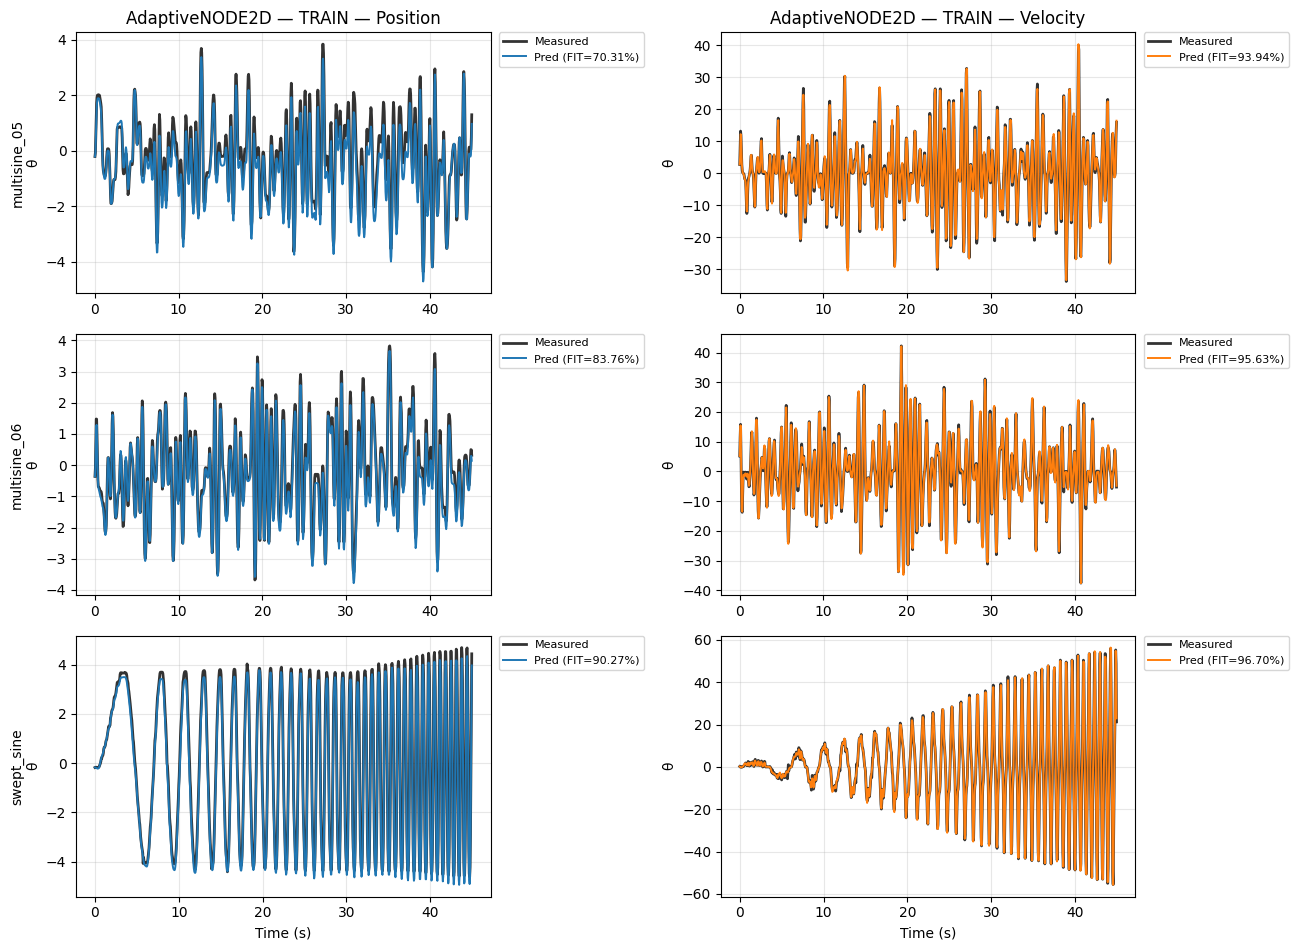

  [AdaptiveNODE2D] TEST -> random_steps_01: FITθ=31.77% RMSEθ=1.73920 | random_steps_02: FITθ=36.20% RMSEθ=1.59059


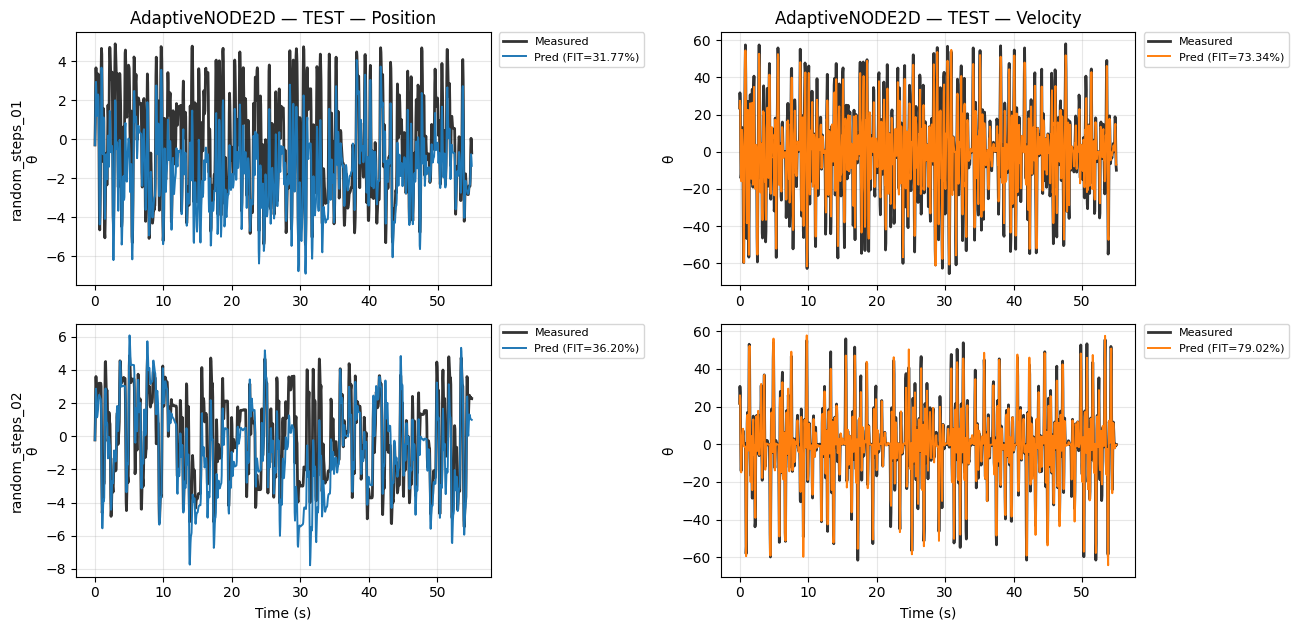

In [8]:
adaptive_ode_eval = RealtimeEvaluator(
    "AdaptiveNODE2D", "ode", rt_eval_splits, eval_every=500,
)
adaptive_ode = train_node_multi(
    adaptive_ode,
    "AdaptiveNODE2D",
    epochs=5000,
    lr=0.005,
    k_steps=20,
    batch_size=128,
    log_every=500,
    eval_callback=adaptive_ode_eval.run,
    eval_every=500,
)
_ = evaluate_and_plot_model("AdaptiveNODE2D", adaptive_ode, "ode", include_train=True, include_test=True)

### 6.1) VanillaNCDE2D

Dynamics:
$$
\dot{x}(t)=f_{\Theta}(\theta,\dot\theta,u,\dot{u}),\quad x=[\theta,\dot\theta]^\top
$$

Neural network used in this notebook (`hidden_dim=128`):
$$
[\theta,\dot\theta,u,\dot{u}]\in\mathbb{R}^{4}\xrightarrow{\mathrm{Linear}(4,128)+\mathrm{SELU}+\mathrm{AlphaDropout}(0.05)}\xrightarrow{\mathrm{Linear}(128,128)+\mathrm{SELU}+\mathrm{AlphaDropout}(0.05)}\xrightarrow{\mathrm{Linear}(128,64)+\mathrm{SELU}}\xrightarrow{\mathrm{Linear}(64,2)}[\dot\theta,\ddot\theta]
$$
- Both $u(t)$ and $\dot{u}(t)$ are obtained from linear interpolation between samples.

Batching strategy (time windows):
- Per epoch: one train dataset + `B=128` sampled windows.
- Window length: `K=20` samples (`k_steps=20`) `≈ 1.0 s`.

Objective:
$$
\min_{\Theta}\;\mathcal{L}_{\mathrm{MS}}(\Theta)=\frac{1}{BK}\sum_{b=1}^{B}\sum_{k=1}^{K}\left\|\hat{x}^{(b)}_{k}-x^{(b)}_{k}\right\|_2^2
$$

--- Training VanillaNCDE2D ---
--- Training VanillaNCDE2D  (K=20, B=128, epochs=5000) ---
  Epoch     0 | Loss: 123.960289  (multisine_05)
  [RT] VanillaNCDE2D    | ep     0 | train 123.960289 | val:multisine_05 FITθ=-159.47% RMSEθ=3.36341 | val:multisine_06 FITθ=-45.41% RMSEθ=1.93389 | val:swept_sine FITθ=-199.26% RMSEθ=11.04567 | test:random_steps_01 FITθ=-794.59% RMSEθ=22.80247 | test:random_steps_02 FITθ=-515.24% RMSEθ=15.33878
  Epoch   500 | Loss: 0.391617  (multisine_06)
  [RT] VanillaNCDE2D    | ep   500 | train 0.391617 | val:multisine_05 FITθ=8.76% RMSEθ=1.18274 | val:multisine_06 FITθ=3.72% RMSEθ=1.28054 | val:swept_sine FITθ=-22.53% RMSEθ=4.52251 | test:random_steps_01 FITθ=-34.20% RMSEθ=3.42065 | test:random_steps_02 FITθ=-22.16% RMSEθ=3.04572
  Epoch  1000 | Loss: 0.228360  (swept_sine)
  [RT] VanillaNCDE2D    | ep  1000 | train 0.228360 | val:multisine_05 FITθ=78.25% RMSEθ=0.28190 | val:multisine_06 FITθ=79.12% RMSEθ=0.27764 | val:swept_sine FITθ=93.70% RMSEθ=0.23254 | t

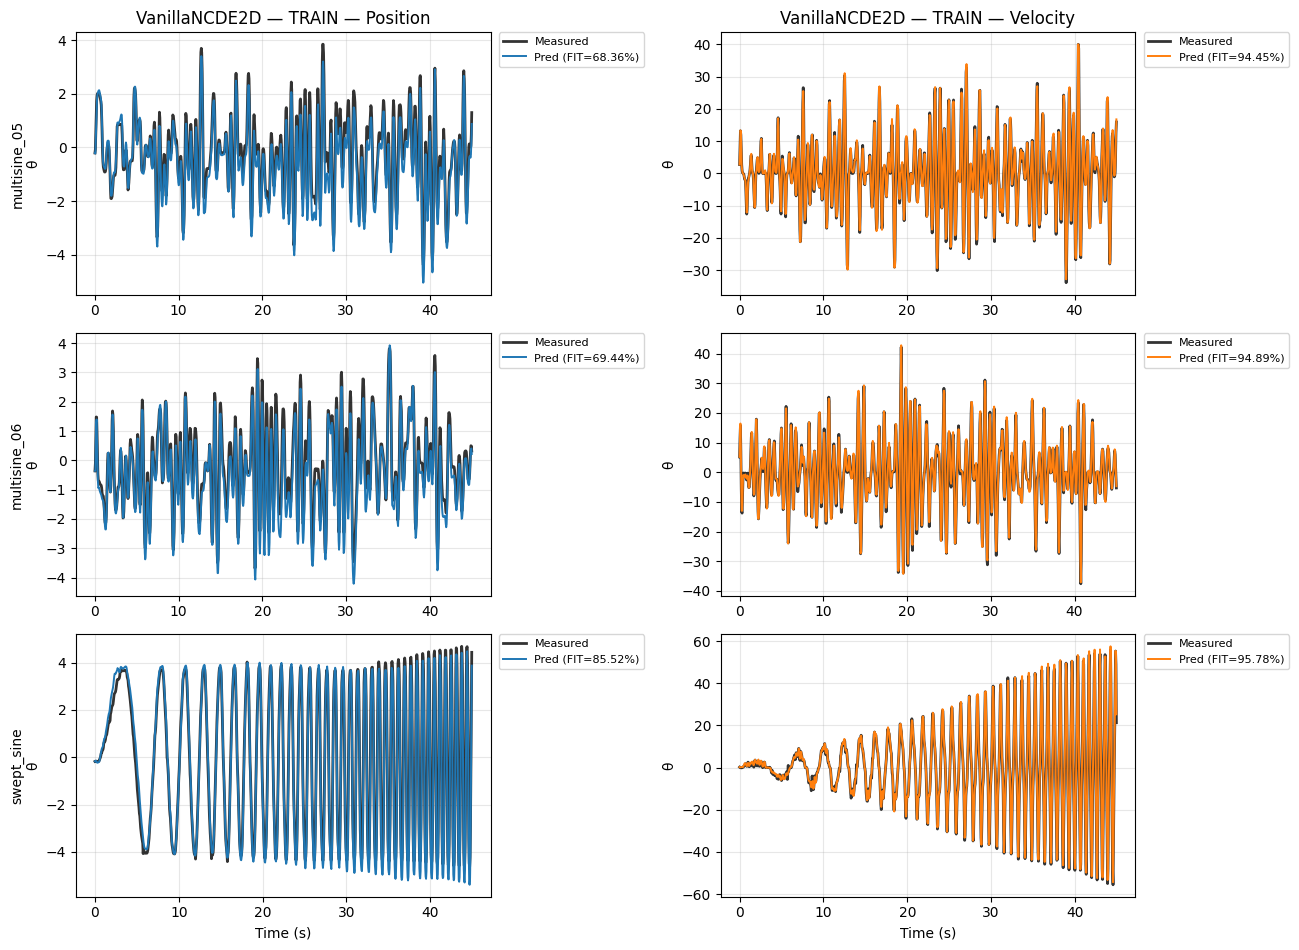

  [VanillaNCDE2D] TEST -> random_steps_01: FITθ=22.35% RMSEθ=1.97923 | random_steps_02: FITθ=23.14% RMSEθ=1.91618


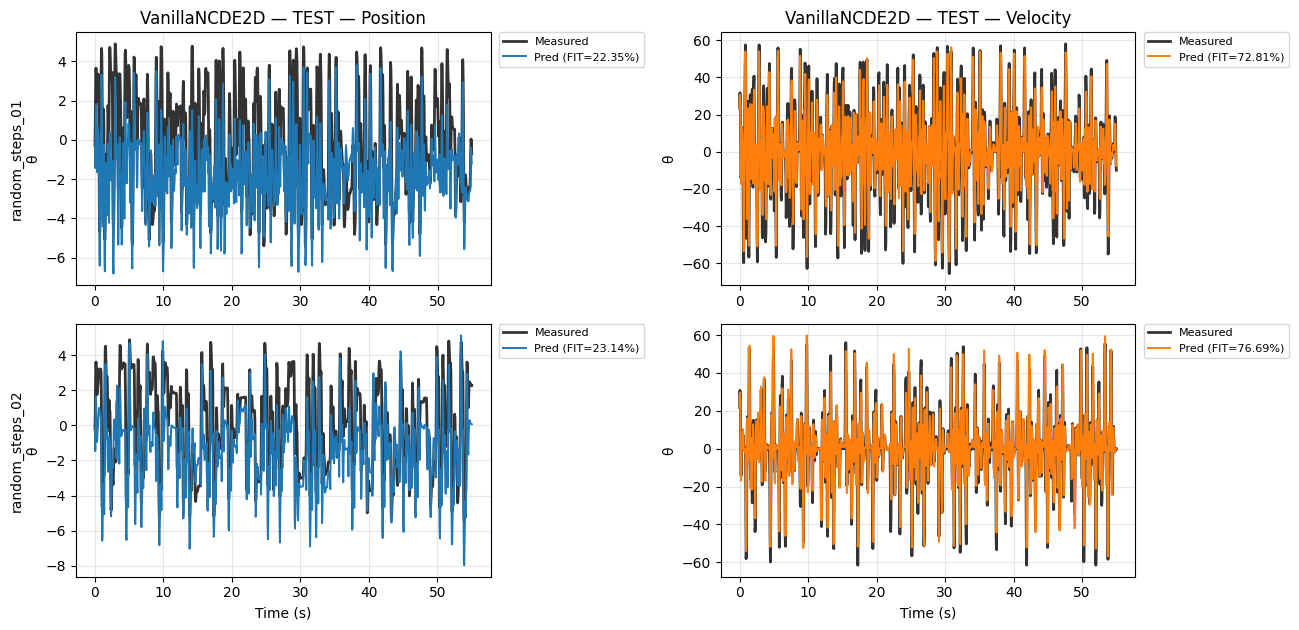

{'train': {'multisine_05': {'rmse_pos': np.float64(0.43963534684382094),
   'rmse_vel': np.float64(0.5965592226129534),
   'r2_pos': np.float64(0.8999141075742879),
   'r2_vel': np.float64(0.9969218927643961),
   'fit_pos': np.float64(68.36364552833054),
   'fit_vel': np.float64(94.45193075421376),
   't': array([ 0.        ,  0.049997  ,  0.099994  ,  0.14999101,  0.19998801,
           0.24998501,  0.29998201,  0.34997901,  0.39997602,  0.44997302,
           0.49997002,  0.54996699,  0.59996402,  0.64996099,  0.69995803,
           0.749955  ,  0.79995203,  0.849949  ,  0.89994603,  0.94994301,
           0.99994004,  1.04993701,  1.09993398,  1.14993107,  1.19992805,
           1.24992502,  1.29992199,  1.34991908,  1.39991605,  1.44991302,
           1.49991   ,  1.54990709,  1.59990406,  1.64990103,  1.699898  ,
           1.7498951 ,  1.79989207,  1.84988904,  1.89988601,  1.9498831 ,
           1.99988008,  2.04987717,  2.09987402,  2.14987111,  2.1998682 ,
           2.2498650

In [9]:
print("--- Training VanillaNCDE2D ---")
vanilla_ncde_eval = RealtimeEvaluator("VanillaNCDE2D", "ode", rt_eval_splits, eval_every=500)
vanilla_ncde = train_node_multi(
    vanilla_ncde,
    "VanillaNCDE2D",
    epochs=5000,
    lr=0.01,
    k_steps=20,
    batch_size=128,
    log_every=500,
    eval_callback=vanilla_ncde_eval.run,
    eval_every=500,
)
evaluate_and_plot_model("VanillaNCDE2D", vanilla_ncde, "ode", include_train=True, include_test=True)

### 6.2) StructuredNCDE2D

Dynamics:
$$
\dot{\theta}=\omega,\qquad \dot{\omega}=f_{\Theta}(\theta,\omega,u,\dot{u})
$$

Neural network used in this notebook (`hidden_dim=128`):
$$
[\theta,\dot\theta,u,\dot{u}]\in\mathbb{R}^{4}\xrightarrow{\mathrm{Linear}(4,128)+\mathrm{SELU}+\mathrm{AlphaDropout}(0.05)}\xrightarrow{\mathrm{Linear}(128,128)+\mathrm{SELU}+\mathrm{AlphaDropout}(0.05)}\xrightarrow{\mathrm{Linear}(128,64)+\mathrm{SELU}}\xrightarrow{\mathrm{Linear}(64,1)}\ddot\theta
$$
- Kinematics are explicit: $\dot\theta=\omega$ is hardcoded.

Batching strategy (time windows):
- Per epoch: one train dataset + `B=128` sampled windows.
- Window length: `K=20` samples (`k_steps=20`) `≈ 1.0 s`.

Objective:
$$
\min_{\Theta}\;\mathcal{L}_{\mathrm{MS}}(\Theta)=\frac{1}{BK}\sum_{b=1}^{B}\sum_{k=1}^{K}\left\|\hat{x}^{(b)}_{k}-x^{(b)}_{k}\right\|_2^2
$$

In [ ]:
print("--- Training StructuredNCDE2D ---")
structured_ncde_eval = RealtimeEvaluator("StructuredNCDE2D", "ode", rt_eval_splits, eval_every=500)
structured_ncde = train_node_multi(
    structured_ncde,
    "StructuredNCDE2D",
    epochs=5000,
    lr=0.01,
    k_steps=20,
    batch_size=128,
    log_every=500,
    eval_callback=structured_ncde_eval.run,
    eval_every=500,
)
evaluate_and_plot_model("StructuredNCDE2D", structured_ncde, "ode", include_train=True, include_test=True)

--- Training StructuredNCDE2D ---
--- Training StructuredNCDE2D  (K=20, B=128, epochs=5000) ---
  Epoch     0 | Loss: 127.809044  (multisine_06)
  [RT] StructuredNCDE2D | ep     0 | train 127.809044 | val:multisine_05 FITθ=-574.77% RMSEθ=8.74677 | val:multisine_06 FITθ=-709.41% RMSEθ=10.76513 | val:swept_sine FITθ=-1880.59% RMSEθ=73.10294 | test:random_steps_01 FITθ=-62797.32% RMSEθ=1603.20673 | test:random_steps_02 FITθ=-38960.32% RMSEθ=973.82809
  Epoch   500 | Loss: 0.347829  (swept_sine)
  [RT] StructuredNCDE2D | ep   500 | train 0.347829 | val:multisine_05 FITθ=78.79% RMSEθ=0.27494 | val:multisine_06 FITθ=73.40% RMSEθ=0.35373 | val:swept_sine FITθ=58.34% RMSEθ=1.53753 | test:random_steps_01 FITθ=-71.70% RMSEθ=4.37642 | test:random_steps_02 FITθ=-9.01% RMSEθ=2.71778
  Epoch  1000 | Loss: 0.180936  (multisine_05)
  [RT] StructuredNCDE2D | ep  1000 | train 0.180936 | val:multisine_05 FITθ=82.11% RMSEθ=0.23184 | val:multisine_06 FITθ=73.09% RMSEθ=0.35792 | val:swept_sine FITθ=30.25% R

### 6.3) AdaptiveNCDE2D

Dynamics:
$$
\dot{\theta}=\omega,\qquad \dot{\omega}=f_{\Theta,\mathrm{base}}(\theta,\omega,u,\dot{u})+f_{\Theta,\mathrm{res}}(\theta,\omega,u,\dot{u})
$$

Base vs residual:
- $f_{\Theta,\mathrm{base}}$: principal structured branch for the core acceleration dynamics.
- $f_{\Theta,\mathrm{res}}$: additive corrective branch (small at initialization) to capture model mismatch.

Neural networks used in this notebook (`hidden_dim=128`):
$$
f_{\Theta,\mathrm{base}}:\,[\theta,\dot\theta,u,\dot{u}]\in\mathbb{R}^{4}\xrightarrow{\mathrm{Linear}(4,128)+\mathrm{SELU}+\mathrm{AlphaDropout}(0.05)}\xrightarrow{\mathrm{Linear}(128,128)+\mathrm{SELU}+\mathrm{AlphaDropout}(0.05)}\xrightarrow{\mathrm{Linear}(128,64)+\mathrm{SELU}}\xrightarrow{\mathrm{Linear}(64,1)}\ddot\theta_{\mathrm{base}}
$$
$$
f_{\Theta,\mathrm{res}}:\,[\theta,\dot\theta,u,\dot{u}]\in\mathbb{R}^{4}\xrightarrow{\mathrm{Linear}(4,64)+\tanh}\xrightarrow{\mathrm{Linear}(64,1)}\ddot\theta_{\mathrm{res}}
$$
- Residual branch is initialized near zero in code (`final weight *= 0.01`, `bias = 0`).

Batching strategy (time windows):
- Per epoch: one train dataset + `B=128` sampled windows.
- Window length: `K=20` samples (`k_steps=20`) `≈ 1.0 s`.

Objective:
$$
\min_{\Theta}\;\mathcal{L}_{\mathrm{MS}}(\Theta)=\frac{1}{BK}\sum_{b=1}^{B}\sum_{k=1}^{K}\left\|\hat{x}^{(b)}_{k}-x^{(b)}_{k}\right\|_2^2
$$

In [ ]:
print("--- Training AdaptiveNCDE2D ---")
adaptive_ncde_eval = RealtimeEvaluator("AdaptiveNCDE2D", "ode", rt_eval_splits, eval_every=500)
adaptive_ncde = train_node_multi(
    adaptive_ncde,
    "AdaptiveNCDE2D",
    epochs=5000,
    lr=0.005,
    k_steps=20,
    batch_size=128,
    log_every=500,
    eval_callback=adaptive_ncde_eval.run,
    eval_every=500,
)
evaluate_and_plot_model("AdaptiveNCDE2D", adaptive_ncde, "ode", include_train=True, include_test=True)

### 6.4) VanillaNSDE2D

Stochastic dynamics:
$$
dx=f_{\Theta}(x,u)\,dt+g_{\Theta}(x,u)\,dW_t,\quad x=[\theta,\dot\theta]^\top
$$

Neural networks used in this notebook (`hidden_dim=128`):
$$
f_{\Theta}\;\text{(state drift)}:\,[\theta,\dot\theta,u]\in\mathbb{R}^{3}\xrightarrow{\mathrm{Linear}(3,128)+\mathrm{SELU}+\mathrm{AlphaDropout}(0.05)}\xrightarrow{\mathrm{Linear}(128,128)+\mathrm{SELU}+\mathrm{AlphaDropout}(0.05)}\xrightarrow{\mathrm{Linear}(128,64)+\mathrm{SELU}}\xrightarrow{\mathrm{Linear}(64,2)}[\dot\theta,\ddot\theta]_{\mathrm{drift}}
$$
$$
g_{\Theta}\;\text{(diagonal state diffusion)}:\,[\theta,\dot\theta,u]\in\mathbb{R}^{3}\xrightarrow{\mathrm{Linear}(3,64)+\tanh}\xrightarrow{\mathrm{Linear}(64,2)}[\sigma_{\theta},\sigma_{\dot\theta}],\quad [\sigma_{\theta},\sigma_{\dot\theta}]=\mathrm{softplus}([\sigma_{\theta},\sigma_{\dot\theta}])+10^{-6}
$$
- In VanillaNSDE2D, both diffusion channels are learned (no hardcoded zero diffusion on position).

Batching strategy (time windows):
- Per epoch: one train dataset + `B=128` sampled windows.
- Window length: `K=20` samples (`k_steps=20`) `≈ 1.0 s`.

Objective:
$$
\min_{\Theta}\;\mathcal{L}_{\mathrm{MS}}(\Theta)=\frac{1}{BK}\sum_{b=1}^{B}\sum_{k=1}^{K}\left\|\hat{x}^{(b)}_{k}-x^{(b)}_{k}\right\|_2^2
$$


In [ ]:
print("--- Training VanillaNSDE2D ---")
vanilla_nsde_eval = RealtimeEvaluator("VanillaNSDE2D", "sde2d", rt_eval_splits, eval_every=500)
vanilla_nsde = train_sde_multi(
    vanilla_nsde,
    "VanillaNSDE2D",
    epochs=5000,
    lr=0.01,
    k_steps=20,
    batch_size=128,
    log_every=500,
    eval_callback=vanilla_nsde_eval.run,
    eval_every=500,
)
evaluate_and_plot_model("VanillaNSDE2D", vanilla_nsde, "sde2d", include_train=True, include_test=True)

### 6.5) StructuredNSDE2D

Dynamics:
$$
\dot{\theta}=\omega,\qquad d\omega=f_{\Theta}(\theta,\omega,u)\,dt+g_{\Theta}(\theta,\omega,u)\,dW_t
$$

Neural networks used in this notebook (`hidden_dim=128`):
$$
f_{\Theta}\;\text{(acceleration drift)}:\,[\theta,\dot\theta,u]\in\mathbb{R}^{3}\xrightarrow{\mathrm{Linear}(3,128)+\mathrm{SELU}+\mathrm{AlphaDropout}(0.05)}\xrightarrow{\mathrm{Linear}(128,128)+\mathrm{SELU}+\mathrm{AlphaDropout}(0.05)}\xrightarrow{\mathrm{Linear}(128,64)+\mathrm{SELU}}\xrightarrow{\mathrm{Linear}(64,1)}\ddot\theta
$$
$$
g_{\Theta}\;\text{(acceleration diffusion)}:\,[\theta,\dot\theta,u]\in\mathbb{R}^{3}\xrightarrow{\mathrm{Linear}(3,64)+\tanh}\xrightarrow{\mathrm{Linear}(64,1)}\sigma_{\ddot\theta},\quad \sigma_{\ddot\theta}=\mathrm{softplus}(\sigma_{\ddot\theta})+10^{-6}
$$
- Diffusion on position is set to zero in code: $\sigma_{\dot\theta}=0$.

Batching strategy (time windows):
- Per epoch: one train dataset + `B=128` sampled windows.
- Window length: `K=20` samples (`k_steps=20`) `≈ 1.0 s`.

Objective:
$$
\min_{\Theta}\;\mathcal{L}_{\mathrm{MS}}(\Theta)=\frac{1}{BK}\sum_{b=1}^{B}\sum_{k=1}^{K}\left\|\hat{x}^{(b)}_{k}-x^{(b)}_{k}\right\|_2^2
$$

In [ ]:
print("--- Training StructuredNSDE2D ---")
structured_nsde_eval = RealtimeEvaluator("StructuredNSDE2D", "sde2d", rt_eval_splits, eval_every=500)
structured_nsde = train_sde_multi(
    structured_nsde,
    "StructuredNSDE2D",
    epochs=5000,
    lr=0.01,
    k_steps=20,
    batch_size=128,
    log_every=500,
    eval_callback=structured_nsde_eval.run,
    eval_every=500,
)
evaluate_and_plot_model("StructuredNSDE2D", structured_nsde, "sde2d", include_train=True, include_test=True)

### 6.6) AdaptiveNSDE2D

Dynamics:
$$
\dot{\theta}=\omega,\qquad d\omega=\left[f_{\Theta,\mathrm{base}}+f_{\Theta,\mathrm{res}}\right](\theta,\omega,u)\,dt+g_{\Theta}(\theta,\omega,u)\,dW_t
$$

Base vs residual:
- $f_{\Theta,\mathrm{base}}$: principal structured drift branch for acceleration.
- $f_{\Theta,\mathrm{res}}$: additive drift correction branch to model residual effects not captured by the base dynamics.

Neural networks used in this notebook (`hidden_dim=128`):
$$
f_{\Theta,\mathrm{base}}:\,[\theta,\dot\theta,u]\in\mathbb{R}^{3}\xrightarrow{\mathrm{Linear}(3,128)+\mathrm{SELU}+\mathrm{AlphaDropout}(0.05)}\xrightarrow{\mathrm{Linear}(128,128)+\mathrm{SELU}+\mathrm{AlphaDropout}(0.05)}\xrightarrow{\mathrm{Linear}(128,64)+\mathrm{SELU}}\xrightarrow{\mathrm{Linear}(64,1)}\ddot\theta_{\mathrm{base}}
$$
$$
f_{\Theta,\mathrm{res}}:\,[\theta,\dot\theta,u]\in\mathbb{R}^{3}\xrightarrow{\mathrm{Linear}(3,64)+\tanh}\xrightarrow{\mathrm{Linear}(64,1)}\ddot\theta_{\mathrm{res}}
$$
$$
g_{\Theta}:\,[\theta,\dot\theta,u]\in\mathbb{R}^{3}\xrightarrow{\mathrm{Linear}(3,64)+\tanh}\xrightarrow{\mathrm{Linear}(64,1)}\sigma_{\ddot\theta},\quad \sigma_{\ddot\theta}=\mathrm{softplus}(\sigma_{\ddot\theta})+10^{-6},\;\sigma_{\dot\theta}=0
$$
- Residual drift branch is near-zero at initialization (`final weight *= 0.01`, `bias = 0`).

Batching strategy (time windows):
- Per epoch: one train dataset + `B=128` sampled windows.
- Window length: `K=20` samples (`k_steps=20`) `≈ 1.0 s`.

Objective:
$$
\min_{\Theta}\;\mathcal{L}_{\mathrm{MS}}(\Theta)=\frac{1}{BK}\sum_{b=1}^{B}\sum_{k=1}^{K}\left\|\hat{x}^{(b)}_{k}-x^{(b)}_{k}\right\|_2^2
$$

In [ ]:
print("--- Training AdaptiveNSDE2D ---")
adaptive_nsde_eval = RealtimeEvaluator("AdaptiveNSDE2D", "sde2d", rt_eval_splits, eval_every=500)
adaptive_nsde = train_sde_multi(
    adaptive_nsde,
    "AdaptiveNSDE2D",
    epochs=5000,
    lr=0.005,
    k_steps=20,
    batch_size=128,
    log_every=500,
    eval_callback=adaptive_nsde_eval.run,
    eval_every=500,
)
evaluate_and_plot_model("AdaptiveNSDE2D", adaptive_nsde, "sde2d", include_train=True, include_test=True)

## 6b) Training — Continuous-Time 1-D Models (Optional) -> ONLY THE POSITION

For each model in this section, the objective is explicit MSE on position:
$$
\min_{\Theta}\;\mathcal{L}_{\theta}(\Theta)
=\frac{1}{T}\sum_{t=1}^{T}\left(\hat{\theta}_t(\Theta)-\theta_t\right)^2
$$

### 6.7) NeuralODE (1-D state)

Dynamics:
$$
\dot{\theta}=f_{\Theta}(\theta,u(t))
$$

Network definition used here (`hidden_layers=[64,64]`, `activation="selu"`):
$$
f_{\Theta}:\,[\theta,u]\in\mathbb{R}^{2}\xrightarrow{\mathrm{Linear}(2,64)+\mathrm{SELU}}\xrightarrow{\mathrm{Linear}(64,64)+\mathrm{SELU}}\xrightarrow{\mathrm{Linear}(64,1)}\dot{\theta}
$$
- The control path $u(t)$ is linearly interpolated between samples.
- Solver in this notebook: `rk4` with step size `dt=Ts`.

Subsequence batching in optimization:
- Window length: `K=50` samples (`\approx 2.5 s` for `Ts\approx 0.05 s`).
- Windows per epoch: `B=24` random windows sampled across the training datasets.

Optimization problem:
$$
\min_{\Theta}\;\mathcal{L}_{\theta}(\Theta)=\frac{1}{B}\sum_{b=1}^{B}\frac{1}{K}\sum_{k=1}^{K}(\hat{\theta}_{b,k}(\Theta)-\theta_{b,k})^2
$$

In [ ]:
if RUN_CT1D_MODELS:
    print("--- Training NeuralODE ---")
    neural_ode_eval = RealtimeEvaluator("NeuralODE", "ct_1d", rt_eval_splits, eval_every=50)
    neural_ode_model.fit(
        u_train_list,
        y_train_list,
        verbose=True,
        wandb_run=WandbLikeRealtimeLogger(neural_ode_model, neural_ode_eval),
        wandb_log_every=1,
    )
    evaluate_and_plot_model("NeuralODE", neural_ode_model, "ct_1d", include_train=True, include_test=True)
else:
    print("Skipping NeuralODE (RUN_CT1D_MODELS=False)")

### 6.8) NeuralSDE (1-D state)

Dynamics:
$$
d\theta=f_{\Theta}(\theta,u)\,dt+g_{\Theta}(\theta,u)\,dW_t
$$

Network definition used here (`hidden_layers=[64,64]`, `diffusion_hidden_layers=[64,64]`):
$$
f_{\Theta}:\,[\theta,u]\in\mathbb{R}^{2}\xrightarrow{\mathrm{Linear}(2,64)+\tanh}\xrightarrow{\mathrm{Linear}(64,64)+\tanh}\xrightarrow{\mathrm{Linear}(64,1)}
$$
$$
g_{\Theta}:\,[\theta,u]\in\mathbb{R}^{2}\xrightarrow{\mathrm{Linear}(2,64)+\tanh}\xrightarrow{\mathrm{Linear}(64,64)+\tanh}\xrightarrow{\mathrm{Linear}(64,1)},\quad \sigma_{\Theta}=\mathrm{softplus}(g_{\Theta})+10^{-6}
$$
- Drift and diffusion are two different MLPs (same widths, different weights).
- The diffusion head final bias is initialized at `-3.0`.
- Solver in this notebook: `euler`.

Subsequence batching in optimization:
- Window length: `K=50` samples (`\approx 2.5 s` for `Ts\approx 0.05 s`).
- Windows per epoch: `B=24` random windows sampled across the training datasets.

Optimization problem (Monte Carlo estimate per epoch):
$$
\min_{\Theta}\;\mathbb{E}_{\omega}\!\left[\frac{1}{B}\sum_{b=1}^{B}\frac{1}{K}\sum_{k=1}^{K}(\hat{\theta}_{b,k}^{(\omega)}(\Theta)-\theta_{b,k})^2\right]
$$

In [ ]:
if RUN_CT1D_MODELS:
    print("--- Training NeuralSDE ---")
    neural_sde_eval = RealtimeEvaluator("NeuralSDE", "ct_1d", rt_eval_splits, eval_every=50)
    neural_sde_model.fit(
        u_train_list,
        y_train_list,
        verbose=True,
        wandb_run=WandbLikeRealtimeLogger(neural_sde_model, neural_sde_eval),
        wandb_log_every=1,
    )
    evaluate_and_plot_model("NeuralSDE", neural_sde_model, "ct_1d", include_train=True, include_test=True)
else:
    print("Skipping NeuralSDE (RUN_CT1D_MODELS=False)")

### 6.9) NeuralCDE (1-D latent state)

Controlled dynamics:
$$
\dot{z}=f_{\Theta}(z)\,\dot{X}(t),\qquad \hat{\theta}=h_{\Theta}(z)
$$

Network definition used here (`hidden_dim=32`, `hidden_layers=[64,64]`):
$$
X(t)=[t,\tilde{u}(t),\tilde{\theta}(t)]\in\mathbb{R}^{3},\quad z_0=\mathrm{Linear}(3,32)\,X(t_0)
$$
$$
f_{\Theta}:\,z\in\mathbb{R}^{32}\xrightarrow{\mathrm{Linear}(32,64)+\mathrm{ReLU}}\xrightarrow{\mathrm{Linear}(64,64)+\mathrm{ReLU}}\xrightarrow{\mathrm{Linear}(64,32\times 3)+\tanh}\in\mathbb{R}^{32\times 3}
$$
$$
h_{\Theta}(z)=\mathrm{Linear}(32,1),\quad X(t)\text{ is built with cubic interpolation in this notebook}
$$
- Input channels are normalized inside the model before interpolation.
- Solver in this notebook: `rk4`.

Subsequence batching in optimization:
- Window length: `K=50` samples (`\approx 2.5 s` for `Ts\approx 0.05 s`).
- Windows per epoch: `B\le 24` (capped by `windows_per_epoch=24`, using random windows across datasets).

Optimization problem:
$$
\min_{\Theta}\;\mathcal{L}_{\theta}(\Theta)=\frac{1}{B}\sum_{b=1}^{B}\frac{1}{K}\sum_{k=1}^{K}(\hat{\theta}_{b,k}(\Theta)-\theta_{b,k})^2
$$

In [ ]:
if RUN_CT1D_MODELS:
    print("--- Training NeuralCDE ---")
    neural_cde_eval = RealtimeEvaluator("NeuralCDE", "ct_1d", rt_eval_splits, eval_every=50)
    neural_cde_model.fit(
        u_train_list,
        y_train_list,
        verbose=True,
        wandb_run=WandbLikeRealtimeLogger(neural_cde_model, neural_cde_eval),
        wandb_log_every=1,
    )
    evaluate_and_plot_model("NeuralCDE", neural_cde_model, "ct_1d", include_train=True, include_test=True)
else:
    print("Skipping NeuralCDE (RUN_CT1D_MODELS=False)")

## 7) Training — Physics-Based Models (LinearPhysics, StribeckPhysics, UDE)

Each model below includes its own equation and optimization objective.

### 7.1) LinearPhysics

Dynamics:
$$
J\ddot{\theta}+R\dot{\theta}+K(\theta+\delta)=\tau u
$$

Subsequence sampling strategy:
- `training_mode="subsequence"`.
- At each epoch: one random dataset and one random window.
- Window length: `sequence_length=50` samples `≈ 2.5 s` (with `Ts≈0.05 s`).

Objective (with one sampled window per epoch, i.e. effectively $B=1$):
$$
\min_{\Phi}\;\mathcal{L}_{\theta}(\Phi)=\frac{1}{K}\sum_{k=1}^{K}(\hat{\theta}_{k}-\theta_{k})^2
$$

In [ ]:
print("--- Training LinearPhysics ---")
linear_physics_eval = RealtimeEvaluator("LinearPhysics", "physics", rt_eval_splits, eval_every=50)
linear_model.fit(
    u_train_list,
    y_train_list,
    verbose=True,
    wandb_run=WandbLikeRealtimeLogger(linear_model, linear_physics_eval),
    wandb_log_every=1,
)
evaluate_and_plot_model("LinearPhysics", linear_model, "physics", include_train=True, include_test=True)

### 7.2) StribeckPhysics

Dynamics:
$$
J\ddot{\theta}+\tau_f(\dot{\theta})+K(\theta+\delta)=\tau u
$$
with Stribeck-type friction in $\tau_f(\dot{\theta})$.

Subsequence sampling strategy:
- `training_mode="subsequence"`.
- At each epoch: one random dataset and one random window.
- Window length: `sequence_length=50` samples `≈ 2.5 s`.

Objective (one sampled window per epoch):
$$
\min_{\Phi}\;\mathcal{L}_{\theta}(\Phi)=\frac{1}{K}\sum_{k=1}^{K}(\hat{\theta}_{k}-\theta_{k})^2
$$

In [ ]:
print("--- Training StribeckPhysics ---")
stribeck_physics_eval = RealtimeEvaluator("StribeckPhysics", "physics", rt_eval_splits, eval_every=50)
stribeck_model.fit(
    u_train_list,
    y_train_list,
    verbose=True,
    wandb_run=WandbLikeRealtimeLogger(stribeck_model, stribeck_physics_eval),
    wandb_log_every=1,
)
evaluate_and_plot_model("StribeckPhysics", stribeck_model, "physics", include_train=True, include_test=True)

### 7.3) UDE (Physics + Neural Residual)

UDE dynamics:
$$
\dot{\theta}=\omega
$$
$$
\dot{\omega}=\frac{\tau u-R\omega-K(\theta+\delta)}{J} + r_{\Theta,\omega}(\omega)
$$

Subsequence batching strategy:
- `training_mode="subsequence"` with random windows sampled each epoch.
- Window length: `sequence_length=64` samples `≈ 3.2 s`.
- Number of sampled windows per epoch: `sequences_per_epoch=32`.

Objective (`subsequence` mode, explicit):
$$
\min_{\Theta,\Phi}\;\mathcal{L}_{\mathrm{UDE}}=\frac{1}{BK}\sum_{b=1}^{B}\sum_{k=1}^{K}
\Big[(\hat{\theta}^{(b)}_k-\theta^{(b)}_k)^2 + \lambda_{\omega}(\hat{\omega}^{(b)}_k-\omega^{(b)}_k)^2\Big]
$$
with $B=32$, $K=64$, $\lambda_{\omega}=\texttt{omega\_loss\_weight}$, and $\omega$ estimated via finite differences.

In [ ]:
print("--- Training UDE ---")
ude_eval = RealtimeEvaluator("UDE", "ct_1d", rt_eval_splits, eval_every=50)
ude_model.fit(
    u_train_list,
    y_train_list,
    verbose=True,
    wandb_run=WandbLikeRealtimeLogger(ude_model, ude_eval),
    wandb_log_every=1,
)
evaluate_and_plot_model("UDE", ude_model, "ct_1d", include_train=True, include_test=True)

## 8) Training — Discrete-Time Models

For each discrete model, we optimize one-step prediction MSE:
$$
\min_{\Theta}\;\mathcal{L}_{\mathrm{OSA}}(\Theta)
=\frac{1}{N}\sum_{k=1}^{N}\left(\hat{y}_{k|k-1}(\Theta)-y_k\right)^2
$$

### 8.1) NARX

Model:
$$
\hat{y}_{k}=f_{\Theta}(y_{k-1},\ldots,y_{k-n_y},u_{k-1},\ldots,u_{k-n_u})
$$
Objective:
$$
\min_{\Theta}\;\mathcal{L}_{\mathrm{OSA}}=\frac{1}{N}\sum_{k=1}^{N}(\hat{y}_{k|k-1}-y_k)^2
$$

In [ ]:
print("--- Training NARX ---")
narx_model.fit(u_train_concat, y_train_concat)
_ = evaluate_and_plot_model("NARX", narx_model, "discrete", include_train=True, include_test=True)

### 8.2) RandomForest

Model:
$$
\hat{y}_{k}=f_{\Theta}(\varphi_k),\quad \varphi_k=[y_{k-1..k-n_y},u_{k-1..k-n_u}]
$$
Objective:
$$
\min_{\Theta}\;\mathcal{L}_{\mathrm{OSA}}=\frac{1}{N}\sum_{k=1}^{N}(\hat{y}_{k|k-1}-y_k)^2
$$

In [ ]:
print("--- Training RandomForest ---")
rf_model.fit(u_train_concat, y_train_concat, verbose=True)
_ = evaluate_and_plot_model("RandomForest", rf_model, "discrete", include_train=True, include_test=True)

### 8.3) NeuralNetwork (MLP autoregresiva)

Model:
$$
\hat{y}_{k}=f_{\Theta}(\varphi_k)
$$
Objective:
$$
\min_{\Theta}\;\mathcal{L}_{\mathrm{OSA}}=\frac{1}{N}\sum_{k=1}^{N}(\hat{y}_{k|k-1}-y_k)^2
$$

In [ ]:
print("--- Training NeuralNetwork ---")
nn_eval = RealtimeEvaluator("NeuralNetwork", "discrete", rt_eval_splits, eval_every=10)
nn_model.fit(
    u_train_concat,
    y_train_concat,
    verbose=True,
    eval_callback=nn_eval.run,
    eval_every=10,
)
_ = evaluate_and_plot_model("NeuralNetwork", nn_model, "discrete", include_train=True, include_test=True)

### 8.4) GRU

Model:
$$
h_k=\mathrm{GRU}_{\Theta}(h_{k-1},u_k),\qquad \hat{y}_k=W h_k+b
$$
Objective:
$$
\min_{\Theta}\;\mathcal{L}_{\mathrm{OSA}}=\frac{1}{N}\sum_{k=1}^{N}(\hat{y}_{k|k-1}-y_k)^2
$$

In [ ]:
print("--- Training GRU ---")
gru_eval = RealtimeEvaluator("GRU", "discrete", rt_eval_splits, eval_every=10)
gru_model.fit(
    u_train_concat,
    y_train_concat,
    verbose=True,
    eval_callback=gru_eval.run,
    eval_every=10,
)
_ = evaluate_and_plot_model("GRU", gru_model, "discrete", include_train=True, include_test=True)

### 8.5) LSTM

Model:
$$
(h_k,c_k)=\mathrm{LSTM}_{\Theta}(h_{k-1},c_{k-1},u_k),\qquad \hat{y}_k=W h_k+b
$$
Objective:
$$
\min_{\Theta}\;\mathcal{L}_{\mathrm{OSA}}=\frac{1}{N}\sum_{k=1}^{N}(\hat{y}_{k|k-1}-y_k)^2
$$

In [ ]:
print("--- Training LSTM ---")
lstm_eval = RealtimeEvaluator("LSTM", "discrete", rt_eval_splits, eval_every=10)
lstm_model.fit(
    u_train_concat,
    y_train_concat,
    verbose=True,
    eval_callback=lstm_eval.run,
    eval_every=10,
)
_ = evaluate_and_plot_model("LSTM", lstm_model, "discrete", include_train=True, include_test=True)

### 8.6) TCN

Model:
$$
\hat{y}_{k}=f_{\Theta}^{\mathrm{TCN}}(u_{1:k},y_{1:k-1})
$$
Objective:
$$
\min_{\Theta}\;\mathcal{L}_{\mathrm{OSA}}=\frac{1}{N}\sum_{k=1}^{N}(\hat{y}_{k|k-1}-y_k)^2
$$

In [ ]:
print("--- Training TCN ---")
tcn_eval = RealtimeEvaluator("TCN", "discrete", rt_eval_splits, eval_every=10)
tcn_model.fit(
    u_train_concat,
    y_train_concat,
    verbose=True,
    eval_callback=tcn_eval.run,
    eval_every=10,
)
_ = evaluate_and_plot_model("TCN", tcn_model, "discrete", include_train=True, include_test=True)

### 8.7) Mamba

Model:
$$
\hat{y}_{k}=f_{\Theta}^{\mathrm{Mamba}}(u_{1:k},y_{1:k-1})
$$
Objective:
$$
\min_{\Theta}\;\mathcal{L}_{\mathrm{OSA}}=\frac{1}{N}\sum_{k=1}^{N}(\hat{y}_{k|k-1}-y_k)^2
$$

In [ ]:
print("--- Training Mamba ---")
mamba_eval = RealtimeEvaluator("Mamba", "discrete", rt_eval_splits, eval_every=10)
mamba_model.fit(
    u_train_concat,
    y_train_concat,
    verbose=True,
    eval_callback=mamba_eval.run,
    eval_every=10,
)
_ = evaluate_and_plot_model("Mamba", mamba_model, "discrete", include_train=True, include_test=True)

## 9) Simulate & Evaluate All Models on Train + Validation + Test Data

Build a unified results dictionary:
`results[model_name][split][dataset_name]` → metrics dict

In [ ]:
# ── Model registry ──
model_registry = {
    "LinearPhysics":   (linear_model,   "physics"),
    "StribeckPhysics": (stribeck_model, "physics"),
    "UDE":             (ude_model,      "ct_1d"),
    "VanillaNODE2D":    (vanilla_ode,    "ode"),
    "StructuredNODE2D": (structured_ode, "ode"),
    "AdaptiveNODE2D":   (adaptive_ode,   "ode"),
    "VanillaNCDE2D":    (vanilla_ncde,   "ode"),
    "StructuredNCDE2D": (structured_ncde, "ode"),
    "AdaptiveNCDE2D":   (adaptive_ncde,  "ode"),
    "VanillaNSDE2D":    (vanilla_nsde,   "sde2d"),
    "StructuredNSDE2D": (structured_nsde, "sde2d"),
    "AdaptiveNSDE2D":   (adaptive_nsde,  "sde2d"),
    "NARX":            (narx_model,     "discrete"),
    "RandomForest":    (rf_model,       "discrete"),
    "NeuralNetwork":   (nn_model,       "discrete"),
    "GRU":             (gru_model,      "discrete"),
    "LSTM":            (lstm_model,     "discrete"),
    "TCN":             (tcn_model,      "discrete"),
    "Mamba":           (mamba_model,    "discrete"),
}

if RUN_CT1D_MODELS:
    model_registry.update({
        "NeuralODE": (neural_ode_model, "ct_1d"),
        "NeuralSDE": (neural_sde_model, "ct_1d"),
        "NeuralCDE": (neural_cde_model, "ct_1d"),
    })

# Use the immediate results accumulated during training.
results = dict(results_live)

# Backfill any model that was not evaluated during its own training cell.
backfill_splits = collect_eval_splits(include_train=True, include_val=False, include_test=True)
for model_name, (model_obj, mtype) in model_registry.items():
    if model_name in results:
        continue
    try:
        results[model_name] = evaluate_model_results(model_name, model_obj, mtype, backfill_splits)
        print(f"  Backfilled metrics for {model_name}")
    except Exception as exc:
        print(f"  ⚠ {model_name}: {type(exc).__name__} -> {exc}")

print("Simulation & evaluation complete!")

## 10) Summary Tables — Grouped by Model Family

In [ ]:
PHYSICS_MODELS  = ["LinearPhysics", "StribeckPhysics", "UDE"]
CT_MODELS_2D    = [
    "VanillaNODE2D", "StructuredNODE2D", "AdaptiveNODE2D",
    "VanillaNCDE2D", "StructuredNCDE2D", "AdaptiveNCDE2D",
    "VanillaNSDE2D", "StructuredNSDE2D", "AdaptiveNSDE2D",
]
CT_MODELS_1D = ["NeuralODE", "NeuralSDE", "NeuralCDE"] if RUN_CT1D_MODELS else []
CT_MODELS = CT_MODELS_2D + CT_MODELS_1D

DISCRETE_MODELS = [
    "NARX", "RandomForest", "NeuralNetwork",
    "GRU", "LSTM", "TCN", "Mamba",
]

def print_metrics_table(results, split, metric_key, model_subset=None, fmt=".1f"):
    """Print a formatted metrics table for a given split and metric."""
    models = model_subset or list(results.keys())
    models = [m for m in models if m in results and split in results[m] and results[m][split]]
    if not models:
        print("  (no results)")
        return
    ds_names = list(results[models[0]][split].keys())
    header = f"{'Model':<20}" + "".join(f"{n:>16}" for n in ds_names) + f"{'Mean':>10}"
    print(header)
    print("-" * len(header))
    for model_name in models:
        vals = [results[model_name][split].get(dn, {}).get(metric_key, float("nan"))
                for dn in ds_names]
        row = f"{model_name:<20}" + "".join(f"{v:>16{fmt}}" for v in vals)
        row += f"{np.nanmean(vals):>10{fmt}}"
        print(row)

# ── Print all tables ──
for group_name, group_models in [
    ("PHYSICS-BASED", PHYSICS_MODELS),
    ("CONTINUOUS-TIME NEURAL (ODE/CDE/SDE)", CT_MODELS),
    ("DISCRETE-TIME", DISCRETE_MODELS),
]:
    print(f"\n{'='*80}")
    print(f"  {group_name}")
    print(f"{'='*80}")

    for split, split_label in [("train", "TRAINING"), ("test", "HOLDOUT TEST")]:
        for metric, metric_label, fmt in [
            ("fit_pos", f"{split_label} — FIT% (Position)", ".1f"),
            ("fit_vel", f"{split_label} — FIT% (Velocity)", ".1f"),
            ("r2_pos",  f"{split_label} — R² (Position)", ".4f"),
            ("r2_vel",  f"{split_label} — R² (Velocity)", ".4f"),
        ]:
            print(f"\n  {metric_label}")
            print(f"  {'-'*60}")
            print_metrics_table(results, split, metric, group_models, fmt=fmt)

## 11) Visualization — Physics-Based Models (Train + Holdout)

In [ ]:
# ── Color / style definitions ──
colors = {
    # Physics-based
    "LinearPhysics": "tab:blue", "StribeckPhysics": "tab:orange", "UDE": "gold",
    # Continuous-time 2-D neural ODE
    "VanillaNODE2D": "tab:green", "StructuredNODE2D": "tab:purple",
    "AdaptiveNODE2D": "tab:brown",
    "VanillaNCDE2D": "teal", "StructuredNCDE2D": "mediumseagreen",
    "AdaptiveNCDE2D": "darkslategray",
    "VanillaNSDE2D": "dodgerblue", "StructuredNSDE2D": "royalblue",
    "AdaptiveNSDE2D": "navy",
    # Continuous-time 1-D
    "NeuralODE": "limegreen", "NeuralSDE": "deepskyblue", "NeuralCDE": "orchid",
    # Discrete
    "NARX": "tab:cyan", "RandomForest": "darkgreen",
    "NeuralNetwork": "salmon",
    "GRU": "tab:red", "LSTM": "tab:olive",
    "TCN": "slateblue", "Mamba": "darkorange",
}
styles = {
    "LinearPhysics": "-", "StribeckPhysics": "--", "UDE": "-.",
    "VanillaNODE2D": ":", "StructuredNODE2D": "-.",
    "AdaptiveNODE2D": (0, (3, 1, 1, 1)),
    "VanillaNCDE2D": "-", "StructuredNCDE2D": "--", "AdaptiveNCDE2D": ":",
    "VanillaNSDE2D": "-.", "StructuredNSDE2D": (0, (4, 1)),
    "AdaptiveNSDE2D": (0, (3, 1, 1, 1)),
    "NeuralODE": "-", "NeuralSDE": "--", "NeuralCDE": ":",
    "NARX": "-", "RandomForest": "--", "NeuralNetwork": ":",
    "GRU": "-.", "LSTM": (0, (3, 1, 1, 1)),
    "TCN": "-", "Mamba": "--",
}

def plot_group(results, model_subset, split, ds_name, title_suffix=""):
    """Plot position + velocity comparison for one group of models."""
    models = [m for m in model_subset if m in results
              and split in results[m] and ds_name in results[m][split]]
    if not models:
        return
    fig, axes = plt.subplots(2, 1, figsize=(14, 7), sharex=True)
    r0 = results[models[0]][split][ds_name]
    t_plot = r0["t"]
    y_true = r0["y_true"]

    for ax_idx, (sig, ylabel) in enumerate([(0, "Position (θ)"), (1, "Velocity (θ̇)")]):
        ax = axes[ax_idx]
        ax.plot(t_plot, y_true[:, sig], "k-", alpha=0.6, lw=2.5, label="Measured", zorder=10)
        for model_name in models:
            r = results[model_name][split][ds_name]
            fit_key = "fit_pos" if sig == 0 else "fit_vel"
            ax.plot(r["t"], r["y_pred"][:, sig],
                    linestyle=styles.get(model_name, "-"),
                    color=colors.get(model_name, "gray"), lw=1.5,
                    label=f"{model_name} ({r[fit_key]:.1f}%)")
        ax.set_ylabel(ylabel, fontsize=12)
        ax.legend(
            fontsize=9,
            loc="upper left",
            bbox_to_anchor=(1.02, 1.0),
            borderaxespad=0.0,
            framealpha=0.9,
        )
        ax.grid(True, alpha=0.3)
    axes[0].set_title(f"{ds_name} [{split.upper()}]{title_suffix}", fontsize=14, fontweight="bold")
    axes[1].set_xlabel("Time (s)", fontsize=12)
    plt.tight_layout(rect=[0, 0, 0.82, 1])
    plt.show()

# ── Physics models: one train + all test ──
plot_group(results, PHYSICS_MODELS, "train", train_datasets[0]["name"])
for ds in test_datasets:
    plot_group(results, PHYSICS_MODELS, "test", ds["name"], " — HOLDOUT")

## 12) Visualization — Continuous-Time Neural Models (NODE2D/NCDE2D/NSDE2D) (Train + Holdout)

In [ ]:
plot_group(results, CT_MODELS, "train", train_datasets[0]["name"])
for ds in test_datasets:
    plot_group(results, CT_MODELS, "test", ds["name"], " — HOLDOUT")

## 13) Visualization — Discrete-Time Models (Train + Holdout)

Note: velocity for discrete models is **estimated** from predicted position via central
finite differences (not directly predicted by the model).

In [ ]:
plot_group(results, DISCRETE_MODELS, "train", train_datasets[0]["name"])
for ds in test_datasets:
    plot_group(results, DISCRETE_MODELS, "test", ds["name"], " — HOLDOUT")

## 14) Train vs Test Summary Bar Charts

In [ ]:
all_models = PHYSICS_MODELS + CT_MODELS + DISCRETE_MODELS
model_names = [m for m in all_models if m in results]
train_ds_names = [ds["name"] for ds in train_datasets]
test_ds_names  = [ds["name"] for ds in test_datasets]

def _safe_mean(model, split, ds_names, key):
    vals = [results[model][split].get(dn, {}).get(key, np.nan) for dn in ds_names]
    return np.nanmean(vals)

train_fit = [_safe_mean(m, "train", train_ds_names, "fit_pos") for m in model_names]
test_fit  = [_safe_mean(m, "test",  test_ds_names,  "fit_pos") for m in model_names]
train_r2  = [_safe_mean(m, "train", train_ds_names, "r2_pos")  for m in model_names]
test_r2   = [_safe_mean(m, "test",  test_ds_names,  "r2_pos")  for m in model_names]

x = np.arange(len(model_names))
w = 0.35

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 7))

# ── FIT% bar chart ──
bars1 = ax1.bar(x - w/2, train_fit, w, label="Train (mean)", color="steelblue", alpha=0.85)
bars2 = ax1.bar(x + w/2, test_fit,  w, label="Test (mean)",  color="tomato",    alpha=0.85)
ax1.set_ylabel("FIT% (Position)", fontsize=12)
ax1.set_title("FIT% — Train vs Holdout Test", fontsize=14, fontweight="bold")
ax1.set_xticks(x)
ax1.set_xticklabels(model_names, rotation=35, ha="right", fontsize=9)
ax1.legend(
    fontsize=11,
    loc="lower center",
    bbox_to_anchor=(0.5, 1.02),
    ncol=2,
    framealpha=0.9,
)
ax1.grid(axis="y", alpha=0.3)
for bar in list(bars1) + list(bars2):
    h = bar.get_height()
    if not np.isnan(h):
        ax1.text(bar.get_x() + bar.get_width()/2, h + 0.5,
                 f"{h:.1f}", ha="center", va="bottom", fontsize=7)

# ── Separators between groups ──
n_phys = len([m for m in PHYSICS_MODELS if m in results])
n_ct   = len([m for m in CT_MODELS if m in results])
for sep in [n_phys - 0.5, n_phys + n_ct - 0.5]:
    ax1.axvline(sep, color="gray", ls="--", alpha=0.4)
    ax2.axvline(sep, color="gray", ls="--", alpha=0.4)

# ── R² bar chart ──
bars3 = ax2.bar(x - w/2, train_r2, w, label="Train (mean)", color="steelblue", alpha=0.85)
bars4 = ax2.bar(x + w/2, test_r2,  w, label="Test (mean)",  color="tomato",    alpha=0.85)
ax2.set_ylabel("R² (Position)", fontsize=12)
ax2.set_title("R² — Train vs Holdout Test", fontsize=14, fontweight="bold")
ax2.set_xticks(x)
ax2.set_xticklabels(model_names, rotation=35, ha="right", fontsize=9)
ax2.legend(
    fontsize=11,
    loc="lower center",
    bbox_to_anchor=(0.5, 1.02),
    ncol=2,
    framealpha=0.9,
)
ax2.grid(axis="y", alpha=0.3)
ax2.set_ylim(None, 1.05)
for bar in list(bars3) + list(bars4):
    h = bar.get_height()
    if not np.isnan(h):
        ax2.text(bar.get_x() + bar.get_width()/2, h + 0.005,
                 f"{h:.4f}", ha="center", va="bottom", fontsize=6)

plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()

In [ ]:
# ── Velocity FIT% bar chart (all models — velocity estimated from position for discrete/1D) ──
vel_models_list = PHYSICS_MODELS + CT_MODELS + DISCRETE_MODELS
vel_names = [m for m in vel_models_list if m in results]

train_fit_vel = [_safe_mean(m, "train", train_ds_names, "fit_vel") for m in vel_names]
test_fit_vel  = [_safe_mean(m, "test",  test_ds_names,  "fit_vel") for m in vel_names]
train_r2_vel  = [_safe_mean(m, "train", train_ds_names, "r2_vel")  for m in vel_names]
test_r2_vel   = [_safe_mean(m, "test",  test_ds_names,  "r2_vel")  for m in vel_names]

x_v = np.arange(len(vel_names))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 7))

bars1 = ax1.bar(x_v - w/2, train_fit_vel, w, label="Train", color="steelblue", alpha=0.85)
bars2 = ax1.bar(x_v + w/2, test_fit_vel,  w, label="Test",  color="tomato",    alpha=0.85)
ax1.set_ylabel("FIT% (Velocity)", fontsize=12)
ax1.set_title("Velocity FIT% — Train vs Holdout Test", fontsize=14, fontweight="bold")
ax1.set_xticks(x_v)
ax1.set_xticklabels(vel_names, rotation=35, ha="right", fontsize=9)
ax1.legend(
    loc="lower center",
    bbox_to_anchor=(0.5, 1.02),
    ncol=2,
    framealpha=0.9,
)
ax1.grid(axis="y", alpha=0.3)
for bar in list(bars1) + list(bars2):
    h = bar.get_height()
    if not np.isnan(h):
        ax1.text(bar.get_x() + bar.get_width()/2, h + 0.5,
                 f"{h:.1f}", ha="center", va="bottom", fontsize=7)

# Separators
n_phys_v = len([m for m in PHYSICS_MODELS if m in results])
n_ct_v   = len([m for m in CT_MODELS if m in results])
for sep in [n_phys_v - 0.5, n_phys_v + n_ct_v - 0.5]:
    ax1.axvline(sep, color="gray", ls="--", alpha=0.4)
    ax2.axvline(sep, color="gray", ls="--", alpha=0.4)

bars3 = ax2.bar(x_v - w/2, train_r2_vel, w, label="Train", color="steelblue", alpha=0.85)
bars4 = ax2.bar(x_v + w/2, test_r2_vel,  w, label="Test",  color="tomato",    alpha=0.85)
ax2.set_ylabel("R² (Velocity)", fontsize=12)
ax2.set_title("Velocity R² — Train vs Holdout Test", fontsize=14, fontweight="bold")
ax2.set_xticks(x_v)
ax2.set_xticklabels(vel_names, rotation=35, ha="right", fontsize=9)
ax2.legend(
    loc="lower center",
    bbox_to_anchor=(0.5, 1.02),
    ncol=2,
    framealpha=0.9,
)
ax2.grid(axis="y", alpha=0.3)
ax2.set_ylim(None, 1.05)
for bar in list(bars3) + list(bars4):
    h = bar.get_height()
    if not np.isnan(h):
        ax2.text(bar.get_x() + bar.get_width()/2, h + 0.005,
                 f"{h:.4f}", ha="center", va="bottom", fontsize=6)

plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()